# Microlensing Tools
<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

<a href="https://colab.research.google.com/github/rges-pit/data-challenge-notebooks/blob/main/Extras/Microlensing_Tools.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you would like an introduction to python notebooks, please read this tutorial: https://medium.com/codingthesmartway-com-blog/getting-started-with-jupyter-notebook-for-python-4e7082bd5d46

## Learning Goals

## Environment Set-Up

**Dependencies**
This notebook has the following dependencies:

  - `python` (v>=3.11 recommended)
  - `numpy`
  - `matplotlib`
  - `pandas`
  - `scipy`
  - `jupyter`
  - `ipython`
  - `astropy`
  - `pathos` (not available on conda)

You can install these packages by running the next cell

In [ ]:
# COLAB etc
%pip install numpy matplotlib pandas scipy ipython astropy pathos

In [ ]:
# NEXUS-ONLY
%source activate-kernel rges-pit-dc

### Imports

In [9]:
#@title General Imports

# system tools
import os
import sys
from io import StringIO
import time
from typing import Tuple, Callable, Optional, List
import shutil

# data analysis tools
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from scipy.optimize import minimize
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
try:
    from google.colab import sheets  # will only work if you are running on Colab
except:
    pass

# web scrapping tools
import bs4 as bs
import pandas as pd

# parallel processing tools
from pathos.multiprocessing import ProcessingPool as Pool  # for multiprocessing inside jupyter
import multiprocessing as mp  # Ensure this is imported

## Introduction

Welcome to the **Roman Microlensing Data Challenge 2026 (RMDC26)** notebook on **Microlensing Tools**. If you have not already, you can click the link below to access the first notebook in this series: 

[**RMDC26/Nexus Workflow**](roman-workflow.ipynb)

The data challenge is intended to be a semi-realistic representation of the data volume and type expected from the Roman Galactic Bulge Time Domain Survey. Specifically for microlensing events and microlensing false positives.

This notebook is brought to you by the RGES-PIT and is inteneded to be an introductory workbook for users new to microlensing event fitting and physical parameter estimation, users who would like a refresher, or users who would like a comprehensive introduction to tools they have not used before. It is not recommended that you complete this notebook in its entirety. You should make use of the tool look-up table and index to navigate to the section relevant to your interest or issue.

Our aim is to provide you with a centralized resource covering open-source microlensing code applications. It is not designed to provide you with a realistic view of what working with bulk microlensing data involves or the general procedures undertaken to demistify microlensings event data. We will link to resources to understand procedures that are currently implemented in microlensing detection and analysis.  

### What data are used in this notebook?

This notebook primarily uses lightcurves from the [2018 WFIRST Data Challenge](https://www.microlensing-source.org/data-challenge/). The data will be either fetched from an s3 bucket or [cloned](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) and sorted in later sections, depending on your environment. Because the 2018 WFIRST Data Challenge concluded in 2018, we can make full use of the [parameter "truths"](https://en.wikipedia.org/wiki/Statistical_parameter#:~:text=parameter%20describes%20the-,true%20value,-calculated%20from%20the) for each event to verify our fitting processes.

The dataset consists of two lightcurve files for each event or star, representing the data from Roman's `W149` and `Z087` filters. The files are in ASCII format with the columns BJD, Aperture_Magnitude and Error, and follow the file-naming convention: `ulwdc1_nnn_[W149/Z087].txt`

Supplementary files were also provided including `wfirst_ephemeris.txt`, which contains the `BJD` and 3D spacecraft location within the solar system. Information was provided on the surface-brightness color relation for `Z087-W149` to enable lens masses to be determined where applicable.

It should be noted that in the simulated data, the inertial frame of reference was defined with the $x$-axis increasing from the binary primary lens object towards the secondary (less massive) lens object at `t0`, the time of closest approach to the primary lens. If viewed from the solar system barycenter, the inertial frame moves at the relative velocity `vlens_CoM - vobserver(t0)`. The inclination of the orbit is a counter-clockwise rotation about the $x$-axis. $\alpha$ is the angle that the source trajectory made with the $x$-axis (if parallax was 0). Where finite source effects were significant, a linear limb darkening law was applied.

<!--
### <font face="Helvetica" size="5"> What lightcurve models are included in this notebook? </font>

The first data challenge contained the following kinds of lightcurves:

* Cataclysmic Variable Star (CVS) false positive
* Single lens microlensing events
* Binary lens microlensing events

You can expect a much broader set in the current data challenge with the addition of binary source microlensing events and more higher-order effects, including parallax, lens orbital motion, . Higher-order effects included in the first data challenge, which are still included in this data challenge, are finite source effects and ... .

Additional data types included in Data challenge 2 include:
* Astrometric timeseries
* Lens flux measurement
-->

### <font face="Helvetica" size="5"> What codes are used in this notebook? </font>

Some open source microlensing codes:
<!-- add a column for pip and conda -->
| Name | Notes | Maintained | Link | Covered here |
| :-: | :-: | :-: | :-: | :-: |
| MuLensModel | User friendly, single- and binary-lens fitting code. | Yes ([Poleski](https://github.com/rpoleski)) | [GitHub](https://github.com/rpoleski/MulensModel) | [Yes](#mulensmodel) |
| BAGEL | Incorporates photometric and astrometric microlensing. | Yes ([Moving Universe Lab](https://github.com/MovingUniverseLab)) | [GitHub](https://github.com/MovingUniverseLab/BAGLE_Microlensing) | [No](#bagel) |
| VBMicroelensing | A more general version of the binary-lens code [VBBL](https://github.com/valboz/VBBinaryLensing). VBMicrolensing <br>is a tool for efficient computation in gravitational microlensing events <br>using the advanced contour integration method, supporting single, binary <br>and multiple lenses. | Yes ([Bozza](https://github.com/valboz)) | [GitHub](https://github.com/valboz/VBMicrolensing) | [No](#vbmicrolensing)
| pyLIMA | pyLIMA is the first open source software for modeling microlensing <br>events. It should be flexible enough to handle your data and fit it. You can <br>also practice by simulating events. Useful for space-based observations. | Yes ([Bachelet](https://github.com/ebachelet)) | [GitHub](https://github.com/ebachelet/pyLIMA) | [Yes](#pylima) |
| RTModel | Hands-off model fitting with built in model <i>"interpretation"</i> <br>(e.g. determing single-lens vs binary-lens arrangement) | Yes ([Bozza](https://github.com/valboz)) | [Github](https://github.com/valboz/RTModel) | [Yes](RTModel) |
| eesunhong | No general description found. <br>See [Bennett and Rhie (1996)](https://ui.adsabs.harvard.edu/abs/1996ApJ...472..660B/abstract) and [Bennett (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...716.1408B/abstract) | Yes ([Bennett]()) | [GitHub](https://github.com/golmschenk/eesunhong) | No |
| pyLIMASS | Addition to pyLIMA for estimating physical properties of the lens <br>system. See [Bachelet, Hundertmark, and Calchi Novati (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....168...24B/abstract) | Yes ([Bachelet](https://github.com/ebachelet)) | [GitHub](https://github.com/ebachelet/pyLIMA/tree/master/pyLIMA/pyLIMASS) | [Yes](#pylima) |
| popclass | Provides a flexible, probabilistic framework for classifying the lens <br>of a gravitational microlensing event. | Yes ([LLNL](https://github.com/LLNL)) | [GitHub](https://github.com/LLNL/popclass) | [Yes](#popclass) |
| muLAn | Designed for fitting Roman microlensing lightcurve data. | No ([Cassan](https://github.com/ArnaudCassan)/[Ranc](https://github.com/clementranc)) | [GitHub](https://github.com/muLAn-project/muLAn) | [No](#muLAN) |
| triplelens | Calculates light curves and image positions for triple microlensing <br>systems. (When the mass ratio is small (below ~ 1e-5), the solutions <br>from the lens equation solver are more accurate when the origin <br>of the coordinate system is set to be close to the smallest mass.) | No ([Kuang](https://github.com/rkkuang)) | [GitHub](https://github.com/rkkuang/triplelens) | No |
| SingleLensFitter | Fits single lens events with finite source effects | No ([Albrow](https://github.com/MichaelDAlbrow)) | [GitHub](https://github.com/MichaelDAlbrow/SingleLensFitter) | No |
<br>

> This is a replica of the tools list on the [RGES-PIT website](https://rges-pit.org/tools). We would like this table to be a comprehensive list, so if you have an open source code you would like to contribute, please refer to the [contributing documentation](https://github.com/rges-pit/data-challenge-notebooks/blob/main/CONTRIBUTING.md), open a discussion on the [GitHub repo](https://github.com/rges-pit/data-challenge-notebooks/discussion), or submit to or website [portal](https://rges-pit.org/submit/).

### Microlensing learning resources

* [RGES-PIT Minicourse](https://rges-pit.org/outreach_mini_landing/)

  The RGES PIT has developed a microlensing mini course for select students to participate in various Roman-related lectures and activities during the Summer of 2025. The virtual lectures were held in mid May 2025; you can find lecture materials, recordings, and assignments.

* [Microlensing Source](https://www.microlensing-source.org/)

  Microlensing Source is a resource center for all aspects of gravitational microlensing. It aims to make microlensing more accessible for anyone with an interest in the subject - including students considering a career in the field, citizen scientists and those looking for a ready reference.

* [The Microlenser's Guide to the Galaxy](https://github.com/rges-pit/TheMicrolensersGuideToTheGalaxy)

  The goal of this project is to create an all-encompassing collection of Jupyter notebooks—your trusty companions for engaging exercises related to microlensing. Through these notebooks, the insights and experiences of microlensing veterins can light your path as you embark on your journey of discovery and exploration through scientific research.

* [2017 Sagan Workshop](http://nexsci.caltech.edu/workshop/2017/)

  The 2017 Sagan Summer Workshop focus on searching for planets with Roman (previously known as WFIRST) microlensing. Leaders in the field will discussed the importance of microlensing to understanding planetary populations and demographics, especially beyond the snow line. They reviewed the microlensing method, both in the context of current capabilities and the future Roman microlensing survey. In addition, speakers addressed the broad potential of the Romans's Wide Field Imaging microlensing survey for (non-microlensing) science in the galactic bulge. Attendees participated in hands-on group projects related to the Roman microlensing planet survey and had the opportunity to present their own work through short presentations (research POPs) and posters.
  The recordings from this workshop can be found [here](https://www.youtube.com/watch?v=QPfKucBb9B8&list=PLIbTYGsIVYthWRS14eCEK8SK9IOTcaYsf)

* [Glossary of Terms](https://www.microlensing-source.org/glossary/)

  This glossary, from Microlensing Source, is intended as a quick reference, particularly to disambiguate the different symbol sets used by different authors over time. Interested readers are referred to the references at the bottom for a full discussion, especially Skowron et al. (2011), and to the Learning Resources menu.

> This is also a replica of the background material listed on the [resources](https://rges-pit.org/resources/#:~:text=Background%20material,Jupyter%20Notebook%20Course%20%C2%A0) page of the RGES-PIT website.

## Collecting the Data

In this section and we will either stream our data from an s3 bucket or clone it from GitHub. We will also need to organize it in to sensible dataframes.

In [ ]:
#@title Cloning the GitHub repository
# COLAB etc

# clone the microlensing data challenge repo
!git clone https://github.com/microlensing-data-challenge/data-challenge-1.git

# Extract the lightcurve files
!tar -xzvf data-challenge-1/lc.tar.gz -C data-challenge-1/

In [ ]:
# NEXUS-ONLY

### <font face="Helvetica" size="5"> Single Lens Events </font>

This dataset includes 293 lightcurve, 74 of which are single lens events. We can cheat a little and specifically pull out the events that we know to be single lenses, keeping the challenge tractable for completion within the hour, with the added benefit of making the strangley organized `master_file.txt` easier to wrangle.

In [ ]:
#@title Putting everything in a tidy data frame

master_file = '../AAS Workshop/Session B: Single Lens & Pipelines/data-challenge-1/Answers/master_file.txt'
header_file = '../AAS Workshop/Session B: Single Lens & Pipelines/data-challenge-1/Answers/wfirstColumnNumbers.txt'

rows = []
with open(master_file, "r") as f:
    for line in f:
        line = line.strip()
        # Skip empty lines or comment lines
        if not line or line.startswith("#"):
            continue

        tokens = line.split()  # split on whitespace
        # Keep only single-lens events
        if "dcnormffp" not in tokens:
            continue

        # Single-lens lines should have exactly 96 columns
        if len(tokens) != 96:
            continue

        rows.append(tokens)

df_sl = pd.DataFrame(rows)

# make an array of zeros with 97 elements
colnames_96 = np.zeros(96, dtype=object)

# Read the header file
with open(header_file, 'r') as f:
    for line in f:
        line = line.strip()
        # Skip empty lines or comments
        if not line or line.startswith('#'):
            continue
        # The second token is the 'name'
        parts = line.split()
        colnames_96[int(parts[0])] = parts[1]

#For single lenses they are (***Note for these, the mass of the lens is given by the planet mass column, not the host mass column):
#72 - unimportant
#73 - N, number of consecutive W149 data points deviating by >=3 sigma from a flat line
#74 - unimportant
#75 - Delta chi^2 (relative to a flat line)
#76-91 - unimportant
#92 - simulated event type (dcnormffp = single lens or free-floating planet)
#93 - unimportant (I think)
#94 - lightcurve filename root
#95 - Data challenge lightcurve number

# Replace the column names in colnames_96
colnames_96[73] = 'N'
colnames_96[75] = 'Delta chi2'
colnames_96[92] = 'sim type'
colnames_96[94] = 'filename'
colnames_96[95] = 'lc_number'

# Make sure the column names are unique
for i in range(94):
    if colnames_96[i] == '|' or colnames_96[i] == 0:
        colnames_96[i] = 'col_' + str(i)

# Replace the column names in the data_frame
df_sl.columns = colnames_96

# Remove the dummy columns 'col_*'
df_sl = df_sl.loc[:, ~df_sl.columns.str.startswith('col_')]

df_sl

,idx,subrun,field,l,b,ra,dec,src_id,Ds,Rs,...,sigma_q,sigma_rs,sigma_F00,sigma_fs0,sigma_F01,sigma_fs1,sigma_thetaE,sim type,filename,lc_number
0,1694,0,82,1.17028,-2.26944,269.319,-29.0889,9926,7.939,0.212,...,999999,999999,8905.98,76994.9,7414.03,3.44036e+09,-2.69363e+11,dcnormffp,dcnormffp_0_82_1694,5
1,539,0,82,1.05037,-2.20017,269.182,-29.158,16904,10.253,0.361,...,999999,999999,728415,435.739,50.4485,166721,-6.04003e+06,dcnormffp,dcnormffp_0_82_539,17
2,1278,0,82,1.18168,-2.1191,269.177,-29.0038,17351,10.64,0.375,...,999999,999999,2.78749e+06,629.296,7.91374,91347.9,-1.23727e+07,dcnormffp,dcnormffp_0_82_1278,21
3,1479,0,82,1.13373,-2.23737,269.267,-29.1045,8329,7.427,0.212,...,999999,999999,6.98775e+06,250.186,78.6551,59875.6,-979126,dcnormffp,dcnormffp_0_82_1479,22
4,318,0,82,1.08784,-2.21568,269.219,-29.1334,16773,10.169,0.535,...,999999,999999,3.11924e+06,2.92871,0.163627,1.18527,-215.015,dcnormffp,dcnormffp_0_82_318,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,718,0,82,1.17865,-2.19791,269.253,-29.0459,11807,8.458,0.293,...,999999,999999,592405,6337.05,10.9393,8.54477e+06,-1.21792e+09,dcnormffp,dcnormffp_0_82_718,285
70,1378,0,82,1.04452,-2.21048,269.189,-29.1682,2183,7.966,1.576,...,999999,999999,809.398,228.589,1.10915,21.9532,21943.9,dcnormffp,dcnormffp_0_82_1378,286
71,954,0,82,1.04501,-2.16747,269.147,-29.1462,14473,9.202,0.328,...,999999,999999,325492,21090.4,1237.92,1.09519e+08,-1.3671e+10,dcnormffp,dcnormffp_0_82_954,288
72,259,0,82,1.18813,-2.0865,269.149,-28.9819,10930,8.206,0.375,...,999999,999999,2.07119e+06,3929.98,34.1225,1.19947e+07,-5.83016e+08,dcnormffp,dcnormffp_0_82_259,290


The last column in this data frame has the lightcurve number, which we can use to pick out only the lightcurves matching our single-lens event list, for analysis.

In [11]:
#@title Figuring out which files we want

lc_number = df_sl['lc_number'].to_numpy()

lc_file_path_format = 'data-challenge-1/lc/ulwdc1_XXX_filter.txt'

lc_file_paths_W149 = [lc_file_path_format.replace('filter', 'W149')] * len(lc_number)
lc_file_paths_Z087 = [lc_file_path_format.replace('filter', 'Z087')] * len(lc_number)

# replace XXX, from the right, with the lc_number which is not necessarily of length 3
lc_file_paths_W149 = [path.replace('XXX', str(num).zfill(3)) for path, num in zip(lc_file_paths_W149, lc_number)]
lc_file_paths_Z087 = [path.replace('XXX', str(num).zfill(3)) for path, num in zip(lc_file_paths_Z087, lc_number)]

df_sl['lc_file_path_W149'] = lc_file_paths_W149
df_sl['lc_file_path_Z087'] = lc_file_paths_Z087

df_sl

,idx,subrun,field,l,b,ra,dec,src_id,Ds,Rs,...,sigma_F00,sigma_fs0,sigma_F01,sigma_fs1,sigma_thetaE,sim type,filename,lc_number,lc_file_path_W149,lc_file_path_Z087
0,1694,0,82,1.17028,-2.26944,269.319,-29.0889,9926,7.939,0.212,...,8905.98,76994.9,7414.03,3.44036e+09,-2.69363e+11,dcnormffp,dcnormffp_0_82_1694,5,data-challenge-1/lc/ulwdc1_005_W149.txt,data-challenge-1/lc/ulwdc1_005_Z087.txt
1,539,0,82,1.05037,-2.20017,269.182,-29.158,16904,10.253,0.361,...,728415,435.739,50.4485,166721,-6.04003e+06,dcnormffp,dcnormffp_0_82_539,17,data-challenge-1/lc/ulwdc1_017_W149.txt,data-challenge-1/lc/ulwdc1_017_Z087.txt
2,1278,0,82,1.18168,-2.1191,269.177,-29.0038,17351,10.64,0.375,...,2.78749e+06,629.296,7.91374,91347.9,-1.23727e+07,dcnormffp,dcnormffp_0_82_1278,21,data-challenge-1/lc/ulwdc1_021_W149.txt,data-challenge-1/lc/ulwdc1_021_Z087.txt
3,1479,0,82,1.13373,-2.23737,269.267,-29.1045,8329,7.427,0.212,...,6.98775e+06,250.186,78.6551,59875.6,-979126,dcnormffp,dcnormffp_0_82_1479,22,data-challenge-1/lc/ulwdc1_022_W149.txt,data-challenge-1/lc/ulwdc1_022_Z087.txt
4,318,0,82,1.08784,-2.21568,269.219,-29.1334,16773,10.169,0.535,...,3.11924e+06,2.92871,0.163627,1.18527,-215.015,dcnormffp,dcnormffp_0_82_318,29,data-challenge-1/lc/ulwdc1_029_W149.txt,data-challenge-1/lc/ulwdc1_029_Z087.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,718,0,82,1.17865,-2.19791,269.253,-29.0459,11807,8.458,0.293,...,592405,6337.05,10.9393,8.54477e+06,-1.21792e+09,dcnormffp,dcnormffp_0_82_718,285,data-challenge-1/lc/ulwdc1_285_W149.txt,data-challenge-1/lc/ulwdc1_285_Z087.txt
70,1378,0,82,1.04452,-2.21048,269.189,-29.1682,2183,7.966,1.576,...,809.398,228.589,1.10915,21.9532,21943.9,dcnormffp,dcnormffp_0_82_1378,286,data-challenge-1/lc/ulwdc1_286_W149.txt,data-challenge-1/lc/ulwdc1_286_Z087.txt
71,954,0,82,1.04501,-2.16747,269.147,-29.1462,14473,9.202,0.328,...,325492,21090.4,1237.92,1.09519e+08,-1.3671e+10,dcnormffp,dcnormffp_0_82_954,288,data-challenge-1/lc/ulwdc1_288_W149.txt,data-challenge-1/lc/ulwdc1_288_Z087.txt
72,259,0,82,1.18813,-2.0865,269.149,-28.9819,10930,8.206,0.375,...,2.07119e+06,3929.98,34.1225,1.19947e+07,-5.83016e+08,dcnormffp,dcnormffp_0_82_259,290,data-challenge-1/lc/ulwdc1_290_W149.txt,data-challenge-1/lc/ulwdc1_290_Z087.txt


There are a few pieces of information that may need to be known for each event that are not in the lightcurve files. These are stored in event_info.txt

Columns: `"Event_name"` `"Event_number"` `"RA_(deg)"` `"Dec_(deg)"` `"Distance"` `"A_W149"` `"sigma_A_W149"` `"A_Z087"` `"sigma_A_Z087"`

Distance, A_W149/Z087 are an estimate of the distance and extinction in each band of the red clump stars. sigma_A_W149/Z087 are dispersions in the extinction.

In [12]:
#@title Event information data frame

header = ["Event_name",
          "Event_number",
          "RA_(deg)",
          "Dec_(deg)",
          "Distance",
          "A_W149",
          "sigma_A_W149",
          "A_Z087",
          "sigma_A_Z087"
]

event_info = pd.read_csv('/home/meet/data-challenge-notebooks/AAS Workshop/Session B: Single Lens & Pipelines/data-challenge-1/event_info.txt', names=header, delim_whitespace=True)
event_info

/tmp/ipykernel_17599/3475344617.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  event_info = pd.read_csv('/home/meet/data-challenge-notebooks/AAS Workshop/Session B: Single Lens & Pipelines/data-challenge-1/event_info.txt', names=header, delim_whitespace=True)


,Event_name,Event_number,RA_(deg),Dec_(deg),Distance,A_W149,sigma_A_W149,A_Z087,sigma_A_Z087
0,ulwdc1_001,1,269.165,-29.0207,8.18,0.73,0.01,1.41,0.01
1,ulwdc1_002,2,269.959,-30.1918,8.09,0.49,0.01,0.95,0.01
2,ulwdc1_003,3,269.100,-29.0983,8.18,0.73,0.01,1.41,0.01
3,ulwdc1_004,4,268.036,-28.3744,8.25,1.35,0.07,2.60,0.14
4,ulwdc1_005,5,269.319,-29.0889,8.18,0.73,0.01,1.41,0.01
...,...,...,...,...,...,...,...,...,...
288,ulwdc1_289,289,267.813,-28.6965,8.07,1.52,0.07,2.93,0.14
289,ulwdc1_290,290,269.149,-28.9819,8.18,0.73,0.01,1.41,0.01
290,ulwdc1_291,291,267.999,-29.7203,8.57,0.71,0.01,1.36,0.01
291,ulwdc1_292,292,269.151,-29.1433,8.18,0.73,0.01,1.41,0.01


In [13]:
#@title Combining the two data frames

# Convert 'lc_number' to numeric type before merging
merged_sl_df = pd.merge(event_info, df_sl.astype({'lc_number': 'int64'}), left_on='Event_number', right_on='lc_number', how='inner')
merged_sl_df

,Event_name,Event_number,RA_(deg),Dec_(deg),Distance,A_W149,sigma_A_W149,A_Z087,sigma_A_Z087,idx,...,sigma_F00,sigma_fs0,sigma_F01,sigma_fs1,sigma_thetaE,sim type,filename,lc_number,lc_file_path_W149,lc_file_path_Z087
0,ulwdc1_005,5,269.319,-29.0889,8.18,0.73,0.01,1.41,0.01,1694,...,8905.98,76994.9,7414.03,3.44036e+09,-2.69363e+11,dcnormffp,dcnormffp_0_82_1694,5,data-challenge-1/lc/ulwdc1_005_W149.txt,data-challenge-1/lc/ulwdc1_005_Z087.txt
1,ulwdc1_017,17,269.182,-29.1580,8.18,0.73,0.01,1.41,0.01,539,...,728415,435.739,50.4485,166721,-6.04003e+06,dcnormffp,dcnormffp_0_82_539,17,data-challenge-1/lc/ulwdc1_017_W149.txt,data-challenge-1/lc/ulwdc1_017_Z087.txt
2,ulwdc1_021,21,269.177,-29.0038,8.18,0.73,0.01,1.41,0.01,1278,...,2.78749e+06,629.296,7.91374,91347.9,-1.23727e+07,dcnormffp,dcnormffp_0_82_1278,21,data-challenge-1/lc/ulwdc1_021_W149.txt,data-challenge-1/lc/ulwdc1_021_Z087.txt
3,ulwdc1_022,22,269.267,-29.1045,8.18,0.73,0.01,1.41,0.01,1479,...,6.98775e+06,250.186,78.6551,59875.6,-979126,dcnormffp,dcnormffp_0_82_1479,22,data-challenge-1/lc/ulwdc1_022_W149.txt,data-challenge-1/lc/ulwdc1_022_Z087.txt
4,ulwdc1_029,29,269.219,-29.1334,8.18,0.73,0.01,1.41,0.01,318,...,3.11924e+06,2.92871,0.163627,1.18527,-215.015,dcnormffp,dcnormffp_0_82_318,29,data-challenge-1/lc/ulwdc1_029_W149.txt,data-challenge-1/lc/ulwdc1_029_Z087.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,ulwdc1_285,285,269.253,-29.0459,8.18,0.73,0.01,1.41,0.01,718,...,592405,6337.05,10.9393,8.54477e+06,-1.21792e+09,dcnormffp,dcnormffp_0_82_718,285,data-challenge-1/lc/ulwdc1_285_W149.txt,data-challenge-1/lc/ulwdc1_285_Z087.txt
70,ulwdc1_286,286,269.189,-29.1682,8.18,0.73,0.01,1.41,0.01,1378,...,809.398,228.589,1.10915,21.9532,21943.9,dcnormffp,dcnormffp_0_82_1378,286,data-challenge-1/lc/ulwdc1_286_W149.txt,data-challenge-1/lc/ulwdc1_286_Z087.txt
71,ulwdc1_288,288,269.147,-29.1462,8.18,0.73,0.01,1.41,0.01,954,...,325492,21090.4,1237.92,1.09519e+08,-1.3671e+10,dcnormffp,dcnormffp_0_82_954,288,data-challenge-1/lc/ulwdc1_288_W149.txt,data-challenge-1/lc/ulwdc1_288_Z087.txt
72,ulwdc1_290,290,269.149,-28.9819,8.18,0.73,0.01,1.41,0.01,259,...,2.07119e+06,3929.98,34.1225,1.19947e+07,-5.83016e+08,dcnormffp,dcnormffp_0_82_259,290,data-challenge-1/lc/ulwdc1_290_W149.txt,data-challenge-1/lc/ulwdc1_290_Z087.txt


### <font face="Helvetica" size="5"> Triple Lens Events </font>


In [ ]:
try:  # this will only work on Colab.
  sl_sheet = sheets.InteractiveSheet(df=merged_sl_df)
  sl_sheet.show()
  bl_sheet = sheets.InteractiveSheet(df=df_bl)
  bl_sheet.show()
except:
  pass



Great - data successfully wrangled. Let's forget we ever had to live through that and move right along.

## <font face="Helvetica" size="6"> Packages Covered in This Notebook </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

<details>
<summary><font face="Helvetica" size="5">1. MulensModel</font></summary>

[Go to the `MulensModel` section](#mulensmodel)
  * [1.1 Data objects](#11-data-objects)
  * [1.2 Model objects](#12-model-objects)
  * [1.3 Event objects](#13-event-objetcs)
  * [1.4 Fitting](#fitting-framework)
  * [1.5 Higher-order effects](#model-examples)
    - [1S1L](#1s1l-example)
    - [1S2L](#1s2l-example)
    - [1S3L](#1s3l-example)
    - [2S1L](#2s1l-example)
    - [Parallax](#parallax-example)
</details>
<details>
<summary><font face="Helvetica" size="5">2. pyLIMA</font></summary>

[Go to the `pyLIMA` section](#pylima)
  * [2.1 Installation and Setup](#pylima-installation)
  * [2.2 Basic Usage](#pylima-basic)
  * [2.3 Model Examples](#pylima-models)
    - [2.3.1 Single Lens (PSPL)](#pylima-pspl)
    - [2.3.2 Finite Source (FSPL)](#pylima-fspl)
    - [2.3.3 Simulation Capabilities](#pylima-simulation)
  * [2.4 Advanced Features](#pylima-advanced)
    - [2.4.1 Custom Parameter Definitions](#pylima-custom-params)
    - [2.4.2 Multiple Telescopes and Filters](#pylima-multiple-telescopes)
  * [2.5 Performance and Best Practices](#pylima-performance)
</details>
<details>
<summary><font face="Helvetica" size="5">4. RTModel</font></summary>

[Go to the `RTModel` section](#rtmodel)
  * [3.1 Installation and Setup](#rtmodel-installation)
  * [3.2 Data Preparation](#rtmodel-data-prep)
  * [3.3 Basic Usage](#rtmodel-basic-usage)
  * [3.4 Understanding RTModel Output](#rtmodel-output)
  * [3.5 Model Categories](#rtmodel-model-categories)
  * [3.6 Visualization and Results](#rtmodel-visualization)
  * [3.7 Advanced Features](#rtmodel-advanced)
  * [3.8 RTModel vs Other Tools](#rtmodel-comparison)
  * [3.9 Astrophotometric Fitting (RTModel v3.0)](#rtmodel-astrometric)
    - [3.9.1 Astrophotometric Data Format](#rtmodel-astrometric-data)
    - [3.9.2 Astrophotometric Parameters](#rtmodel-astrometric-parameters)
    - [3.9.3 Astrophotometric Fitting](#rtmodel-astrometric-fitting)
    - [3.9.4 Astrometric Visualization](#rtmodel-astrometric-visualization)
    - [3.9.5 Applications and Use Cases](#rtmodel-astrometric-applications)
</details>
<details>
<summary><font face="Helvetica" size="5">4. popclass</font></summary>

[Go to the `popclass` section](#popclass)
  * [4.1 Installation](#popclass-installation)
  * [4.2 Basic Usage Example](#popclass-basic-usage)
  * [4.3 How It Works](#popclass-theory)
  * [4.4 Population Models](#popclass-models)
  * [4.5 Advanced Features](#popclass-advanced)
  * [4.6 Best Practices & Caveats](#popclass-best-practices)
  * [4.7 Further Reading](#popclass-references)
</details>
<!--
<details>
<summary><font face="Helvetica" size="5">5. BAGEL</font></summary> -->
<!--
[Go to the `BAGEL` section](#bagel)
</details>
<details>
<summary><font face="Helvetica" size="5">6. MuLAN</font></summary> -->
<!--
[Go to the `MuLAN` section](#mulan)
</details> -->

## 1. MulensModel

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

At the time of writting this notebook there was an unresolved bug in the `MulensModel` package. The result is that models with finte source effects will raise an error for missing files. You can run all cells in the following subsection to correct it. But basically we need to download the repo's data directory and replace it in the package file.

#### <font face="Helvetica" size="5"> MulensModel package fix

In [ ]:
#@title Installing the package
#reset_cwd()
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ MulensModel-test

In [14]:
#@title Importing the package
import MulensModel as mm

In [ ]:
#@title Clearing the old `data` directory/file
# check this box if you would like to replace the data folder
replace_data_folder = False #@param {type:"boolean"}
skip_next_cell = False

mulensmodel_dir = os.path.dirname(mm.__file__)
data_file_path = os.path.join(mulensmodel_dir, 'data')

if os.path.exists(data_file_path):
  # make sure we have permissions to delete the data file
  os.chmod(os.path.join(mulensmodel_dir, "data"), 0o777)

  if os.path.isfile(data_file_path):
    os.remove(data_file_path)
    print(f"Removed 'data' file from {mulensmodel_dir}")
  elif replace_data_folder:
    shutil.rmtree(data_file_path)
    print(f"Removed 'data' directory from {mulensmodel_dir}")
  else:
    skip_next_cell = True
    print("""MulensModel build looks correct. If it is not working, try selecting
     `replace_data_folder` and running the subsection again.""")
else:
  print(f"No 'data' file or directory found in {mulensmodel_dir}")

In [ ]:
#@title Getting the data tree and cleaning up
if not skip_next_cell:
    # change the working directory to the mulensmodel_dir directory
    os.chdir(mulensmodel_dir)

    # starting from a fresh clone
    if os.path.exists(os.path.join(mulensmodel_dir, "MulensModel")):
        # remove the MulensModel repository
        !chmod -R u+w MulensModel
        !rm -r MulensModel

    # clone the MulensModel repository
    !git clone https://github.com/rpoleski/MulensModel.git

    # move the data directory to the mulensmodel_dir directory
    !mv MulensModel/data ./

    # remove the MulensModel repository
    !chmod -R u+w MulensModel
    !rm -r MulensModel

    # change the working directory back to the original directory
    reset_cwd()

### <font face="Helvetica" size="5"> 1.1 Data Objects </font>

When fitting Roman data with `MulensModel`, we need to make a minor adjustment to our model for data that is not ground based. In `MulensModel` this simply means adding the following keyword to the data object initialization: `ephemerides_file=PATH_TO_THE_FILE`.

> Instructions specific to this data set for `MulensModel` are given [here](https://github.com/rpoleski/MulensModel/blob/master/documents/data_challenge.md).

Most of the data for these events is in the W147 band, so we make the very reasonable decision to just fit those data and not have to deal with mutliple data sets with different $F_\textrm{S}$ and $F_\textrm{B}$ values. That should speen up our fits too. If we wanted to find the color of the source star at a later date we could fit just the flux parameters and leave the microlensing-model parameters fixed (as described in [this notebook](https://github.com/rges-pit/TheMicrolensersGuideToTheGalaxy/blob/main/Notebooks/SingleLens.ipynb)) using a linear regression, which would take a fraction of a second per event.

In [15]:
#@title Collecting the relevent meta data
data_file = merged_sl_df['lc_file_path_W149'][0]
ra = merged_sl_df['RA_(deg)'][0]
dec = merged_sl_df['Dec_(deg)'][0]
print(ra, dec)

# convert decimal ra and dec in degrees to "17h57m16.56s -29d05m20.04s"
coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
hms_dms_string = coord.to_string('hmsdms')
print(f"SkyCoord default: {hms_dms_string}")

269.319 -29.0889
SkyCoord default: 17h57m16.56s -29d05m20.04s


In [16]:
#@title Example L2 `Data` object

# Here is the main difference for space data - we provide the ephemeris for Roman:
EPHEM_FILE = 'data-challenge-1/wfirst_ephemeris_W149.txt'
data_Roman_W149 = mm.MulensData(file_name=data_file,
                                phot_fmt='mag',
                                ephemerides_file=EPHEM_FILE,
                                plot_properties={'color': '#a859e4',
                                                 'label': 'Roman W149'
                                                 },
                                bandpass='H'
                               )

### <font face="Helvetica" size="5"> 1.2 Model Objects </font>

In [17]:
#@title Collecting the meta data
# split the parallax equally out of a lack of better ideas
pi_E_E = np.sqrt(float(merged_sl_df['piE'][0])**2 / 2.0)
pi_E_N = pi_E_E * 1.0

t_0 = float(merged_sl_df['t0'][0])
# Annoyingly, t_0 is in simulation time not HJD so we need to do a conversion
# (https://github.com/microlensing-data-challenge/evaluation_code/blob/master/parse_table1.py)
# line 402
t_0 = t_0 + 2458234.0  # simulation 0 time

In [18]:
#@title Making a dictionary of the guess parameters
# Let's just tidy the "guess" parameters up into a dictionary, for easy accesss
params = dict()
parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "pi_E_N", "pi_E_E"]
params['t_0'] = t_0 * 1.0
params['t_0_par'] = t_0 * 1.0
params['u_0'] = float(merged_sl_df['u0'][0]) * 1.1
params['t_E'] = float(merged_sl_df['tE'][0]) * 1.1
params['rho'] = float(merged_sl_df['rhos'][0]) * 1.1
params['pi_E_N'] = pi_E_E
params['pi_E_E'] = pi_E_E

In [19]:
#@title Example `Model` object

# If we are using parallax, it is also important that we provide the event
# coordinates, or MulensModel can't do necessary calculations
Roman_model = mm.Model({**params},
                        coords=coord,
                        ephemerides_file=EPHEM_FILE
                       )

### <font face="Helvetica" size="5"> 1.3 Event Objects </font>

In [20]:
#@title Example `Event` object

Roman_event = mm.Event(datasets=data_Roman_W149, model=Roman_model)

### <font face="Helvetica" size="5"> 1.4 Fitting Framework </font>

Now we'll set up a comprehensive fitting framework that can handle different model types. We'll use `emcee` for MCMC sampling and demonstrate various microlensing models.

In [18]:
#@title Import additional fitting tools
# !pip install emcee corner
import emcee
from scipy.optimize import minimize
import corner

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [28]:
#@title Define likelihood function for fitting
def log_likelihood(theta, event, parameters_to_fit):
    """Log likelihood function for emcee"""
    try:
        # Update model parameters
        for i, param_name in enumerate(parameters_to_fit):
            if param_name == 'log_rho':
                # Convert log_rho back to rho
                event.model.parameters.rho = 10**theta[i]
            else:
                setattr(event.model.parameters, param_name, theta[i])

        # Fit the fluxes given the current model parameters
        event.fit_fluxes()

        # Get the source and blend fluxes
        ([F_S], F_B) = event.get_flux_for_dataset(event.datasets[0])

        # Calculate chi-squared
        chi2 = event.get_chi2()

        # Add flux priors if needed (optional)
        penalty = 0.0
        if F_B <= 0:
            penalty = ((F_B / 100)**2)  # Penalize negative blend flux
        if F_S <= 0 or (F_S + F_B) <= 0:
            return -np.inf  # Return inf if fluxes are non-physical

        return -0.5 * chi2 - penalty
    except:
        return -np.inf

def run_mcmc_fit(event, parameters_to_fit, initial_guess, nwalkers=32, nsteps=1000, burnin=200):
    """Run MCMC fitting with emcee"""
    ndim = len(parameters_to_fit)

    # Initial positions (slightly perturbed from initial guess)
    pos = np.array(initial_guess) + 1e-4 * np.random.randn(nwalkers, ndim)

    # Use ThreadPool for notebook compatibility
    n_cores = mp.cpu_count()
    print(f"Using {n_cores} threads for MCMC")

    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_likelihood,
            args=(event, parameters_to_fit),
            pool=pool
        )
        sampler.run_mcmc(pos, nsteps, progress=True)

    return sampler

### <font face="Helvetica" size="5"> 1.5 Model Examples </font>

Now let's demonstrate different microlensing models. We'll start with simple models and work our way up to more complex ones.

#### <font face="Helvetica" size="4"> 1.5.1 Single Lens Single Source (1S1L) with Finite Source Effects </font>

Let's start with a simple single lens model that includes finite source effects (ρ parameter).

In [29]:
#@title 1S1L Model Setup
# Select a single lens event for demonstration
event_idx = 0  # First single lens event
data_file = merged_sl_df['lc_file_path_W149'][event_idx]
ra = merged_sl_df['RA_(deg)'][event_idx]
dec = merged_sl_df['Dec_(deg)'][event_idx]
coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Get truth parameters for comparison
t_0_truth = float(merged_sl_df['t0'][event_idx]) + 2458234.0  # Convert to HJD
u_0_truth = float(merged_sl_df['u0'][event_idx])
t_E_truth = float(merged_sl_df['tE'][event_idx])
rho_truth = float(merged_sl_df['rhos'][event_idx])

print(f"Event {event_idx}: Truth parameters")
print(f"  t_0: {t_0_truth:.3f}")
print(f"  u_0: {u_0_truth:.4f}")
print(f"  t_E: {t_E_truth:.2f} days")
print(f"  ρ: {rho_truth:.6f}")

Event 0: Truth parameters
  t_0: 2459816.213
  u_0: -0.0713
  t_E: 1.86 days
  ρ: 0.002806


In [30]:
#@title Load data for 1S1L example
# Load the light curve data
data_1s1l = mm.MulensData(file_name=data_file,
                          phot_fmt='mag',
                          ephemerides_file=EPHEM_FILE,
                          plot_properties={'color': '#a859e4', 'label': 'Roman W149'},
                          bandpass='H')

# Create initial model with finite source effects
params_1s1l = {
    't_0': t_0_truth * 1.0,  # Start with truth values
    'u_0': u_0_truth * 1.1,  # Slightly perturb
    't_E': t_E_truth * 1.1,
    'rho': rho_truth * 1.1,
}

model_1s1l = mm.Model(params_1s1l, coords=coord, ephemerides_file=EPHEM_FILE)
event_1s1l = mm.Event(datasets=data_1s1l, model=model_1s1l)

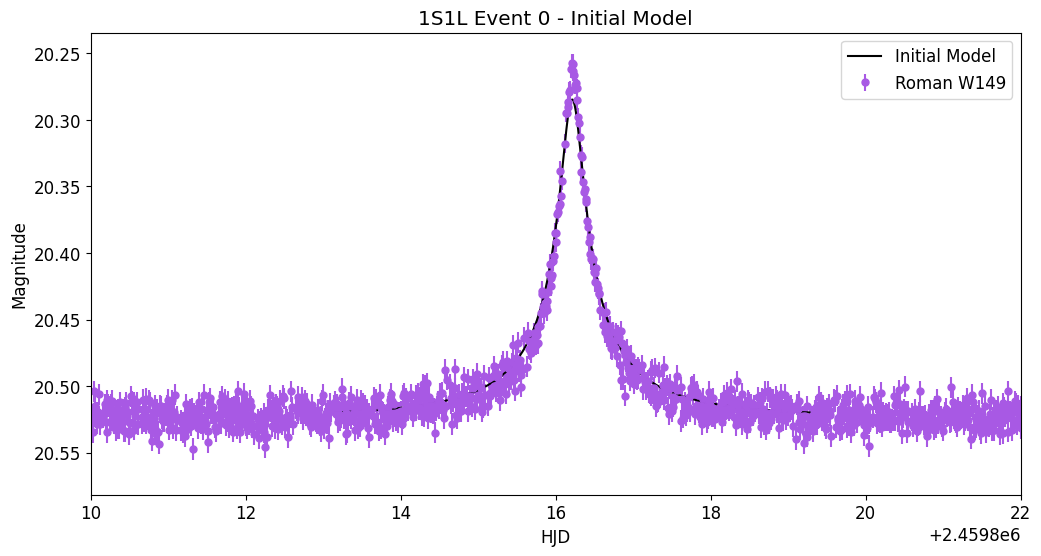

In [31]:
# Plot the initial model
plt.figure(figsize=(12, 6))
event_1s1l.plot_data()
event_1s1l.plot_model(color='black', label='Initial Model')
plt.title(f"1S1L Event {event_idx} - Initial Model")
plt.xlabel("HJD")
plt.ylabel("Magnitude")
plt.xlim(2459810.0, 2459822.0)
plt.legend()
plt.show()

In [32]:
#@title Fit 1S1L model with MCMC
# Set up parameters to fit
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor as ThreadPool

parameters_to_fit_1s1l = ["t_0", "u_0", "t_E", "rho"]
initial_guess_1s1l = [t_0_truth, u_0_truth, t_E_truth, rho_truth]

print("Starting 1S1L MCMC fit...")
start_time = time.time()

# Run MCMC
sampler_1s1l = run_mcmc_fit(event_1s1l, parameters_to_fit_1s1l, initial_guess_1s1l,
                           nwalkers=32, nsteps=500, burnin=100)

# Get results
samples_1s1l = sampler_1s1l.chain[:, 100:, :].reshape((-1, 4))
best_fit_1s1l = np.median(samples_1s1l, axis=0)
uncertainties_1s1l = np.std(samples_1s1l, axis=0)

fit_time = time.time() - start_time
print(f"\n1S1L Fit completed in {fit_time:.1f} seconds")
print("\nResults:")
for i, param in enumerate(parameters_to_fit_1s1l):
    print(f"  {param}: {best_fit_1s1l[i]:.6f} ± {uncertainties_1s1l[i]:.6f}")

# Compare with truth
print("\nComparison with truth:")
truth_values = [t_0_truth, u_0_truth, t_E_truth, rho_truth]
for i, param in enumerate(parameters_to_fit_1s1l):
    diff = best_fit_1s1l[i] - truth_values[i]
    sigma_diff = abs(diff) / uncertainties_1s1l[i]
    print(f"  {param}: {diff:.6f} ({sigma_diff:.2f}σ)")

Starting 1S1L MCMC fit...
Using 16 threads for MCMC


100%|██████████| 500/500 [06:53<00:00,  1.21it/s]


1S1L Fit completed in 414.6 seconds

Results:
  t_0: 2459816.243224 ± 1.984651
  u_0: -0.077533 ± 3.331633
  t_E: 1.855984 ± 4.551560
  rho: 0.043611 ± 0.181134

Comparison with truth:
  t_0: 0.030579 (0.02σ)
  u_0: -0.006261 (0.00σ)
  t_E: 0.000564 (0.00σ)
  rho: 0.040805 (0.23σ)


/home/meet/.local/lib/python3.10/site-packages/MulensModel/fitdata.py:63: UserWarning: Dataset bandpass is H but model does not have a limb-darkening coefficient for H. Assuming zero.
  warnings.warn(msg.format(self.dataset.bandpass))
/home/meet/.local/lib/python3.10/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/meet/.local/lib/python3.10/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


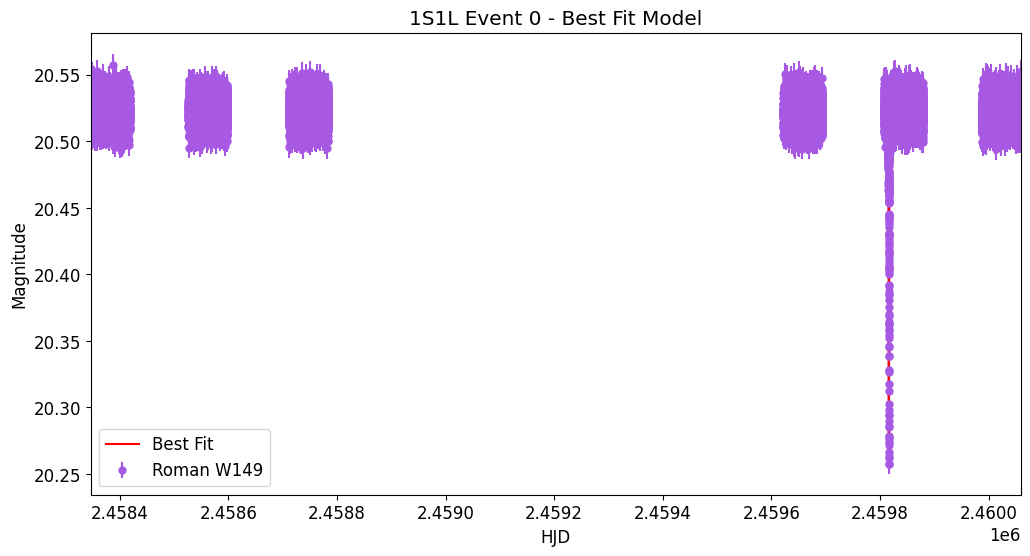

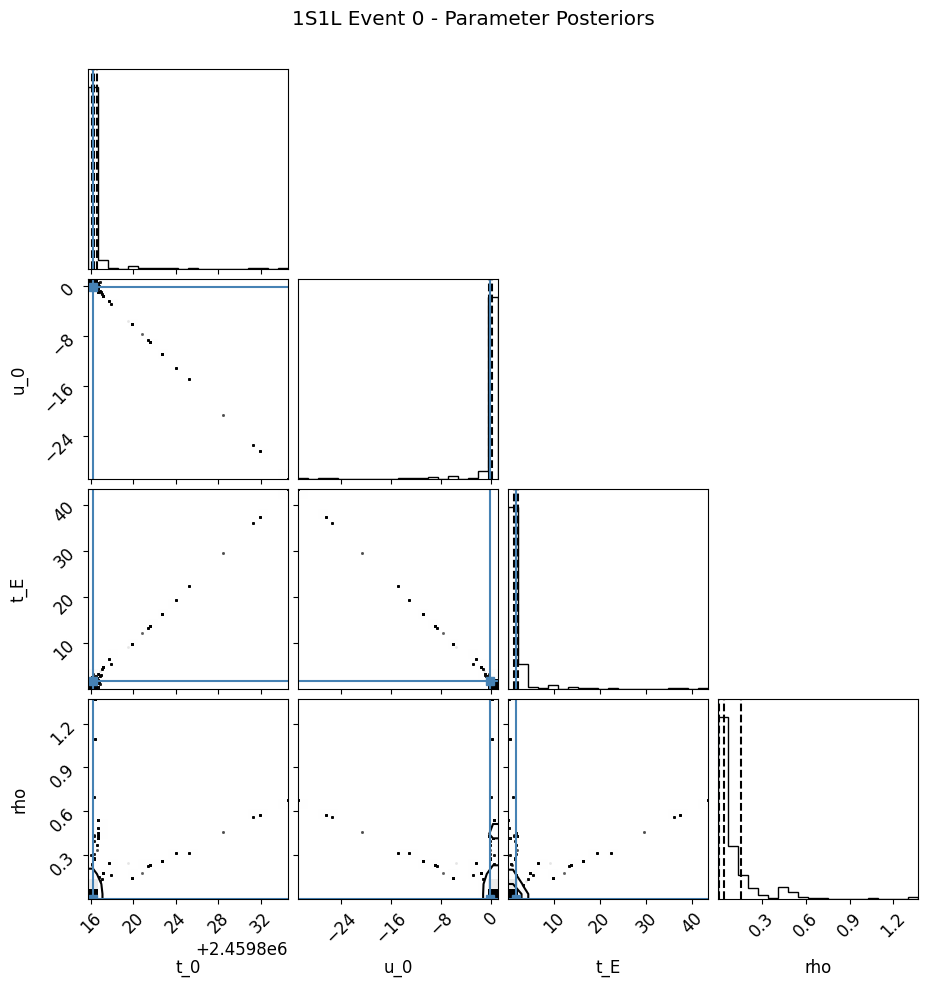

/home/meet/.local/lib/python3.10/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/meet/.local/lib/python3.10/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


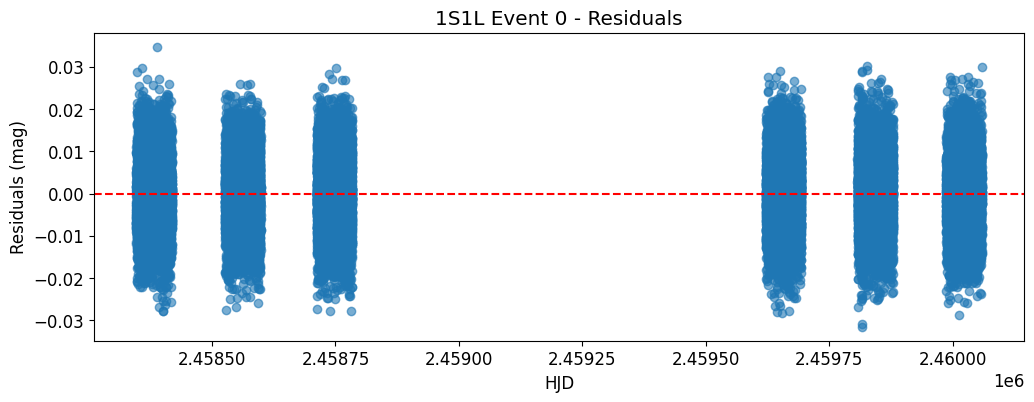

In [34]:
#@title Plot 1S1L results
# Update model with best fit parameters
for i, param_name in enumerate(parameters_to_fit_1s1l):
    setattr(event_1s1l.model.parameters, param_name, best_fit_1s1l[i])
event_1s1l.fit_fluxes()

# Plot light curve with best fit
plt.figure(figsize=(12, 6))
event_1s1l.plot_data()
event_1s1l.plot_model(color='red', label='Best Fit')
plt.gca().invert_yaxis()
plt.title(f"1S1L Event {event_idx} - Best Fit Model")
plt.xlabel("HJD")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Plot corner plot
fig = corner.corner(samples_1s1l, labels=parameters_to_fit_1s1l,
                    truths=truth_values, quantiles=[0.16, 0.5, 0.84])
plt.suptitle(f"1S1L Event {event_idx} - Parameter Posteriors", y=1.02)
plt.show()

# Plot residuals - compute manually since MulensModel Event doesn't have get_residuals()
plt.figure(figsize=(12, 4))
data = event_1s1l.datasets[0]
model_mag = event_1s1l.model.get_lc(times=data.time, source_flux=event_1s1l.fluxes[0][0], blend_flux=event_1s1l.fluxes[0][1])
residuals = data.mag - model_mag
plt.scatter(data.time, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title(f"1S1L Event {event_idx} - Residuals")
plt.xlabel("HJD")
plt.ylabel("Residuals (mag)")
plt.show()

#### <font face="Helvetica" size="4"> 1.5.2 Single Source Binary Lens (1S2L) with Finite Source Effects </font>

Now let's demonstrate a binary lens model. We'll use a simulated binary lens event to show how to fit for the additional parameters.

In [37]:
#@title 1S2L Model Setup
# For this example, we'll create a simulated binary lens event
# In practice, you would load real binary lens data

# Create synthetic binary lens data
def create_binary_lens_data(t_0=2459123.5, u_0=0.1, t_E=25.0, q=0.1, s=1.2, alpha=45.0, rho=0.001):
    """Create synthetic binary lens light curve"""
    # Time array around the event
    t = np.linspace(t_0 - 2*t_E, t_0 + 2*t_E, 200)

    # Create binary lens model
    params = {
        't_0': t_0,
        'u_0': u_0,
        't_E': t_E,
        'q': q,  # mass ratio
        's': s,  # separation
        'alpha': alpha,  # angle
        'rho': rho  # finite source
    }

    model = mm.Model(params, coords=coord, ephemerides_file=EPHEM_FILE)

    # Calculate magnification
    magnification = model.get_magnification(t)

    # Add noise
    mag_0 = 18.0  # baseline magnitude
    mag = mag_0 - 2.5 * np.log10(magnification)
    mag_err = 0.01 * np.ones_like(mag)  # 1% photometric error

    # Add some scatter
    mag += np.random.normal(0, mag_err)

    return t, mag, mag_err, params

# Create the synthetic data
t_binary, mag_binary, mag_err_binary, truth_params_binary = create_binary_lens_data()

print("Synthetic 1S2L Event - Truth Parameters:")
for key, value in truth_params_binary.items():
    print(f"  {key}: {value}")

Synthetic 1S2L Event - Truth Parameters:
  t_0: 2459123.5
  u_0: 0.1
  t_E: 25.0
  q: 0.1
  s: 1.2
  alpha: 45.0
  rho: 0.001


/home/meet/.local/lib/python3.10/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/meet/.local/lib/python3.10/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


/home/meet/.local/lib/python3.10/site-packages/MulensModel/fitdata.py:63: UserWarning: Dataset bandpass is H but model does not have a limb-darkening coefficient for H. Assuming zero.
  warnings.warn(msg.format(self.dataset.bandpass))
/home/meet/.local/lib/python3.10/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/meet/.local/lib/python3.10/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


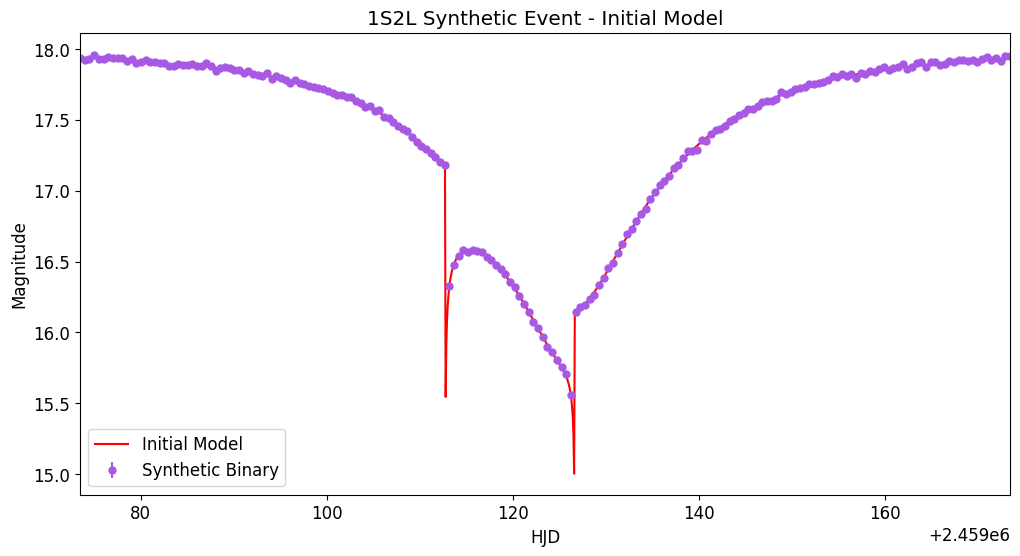

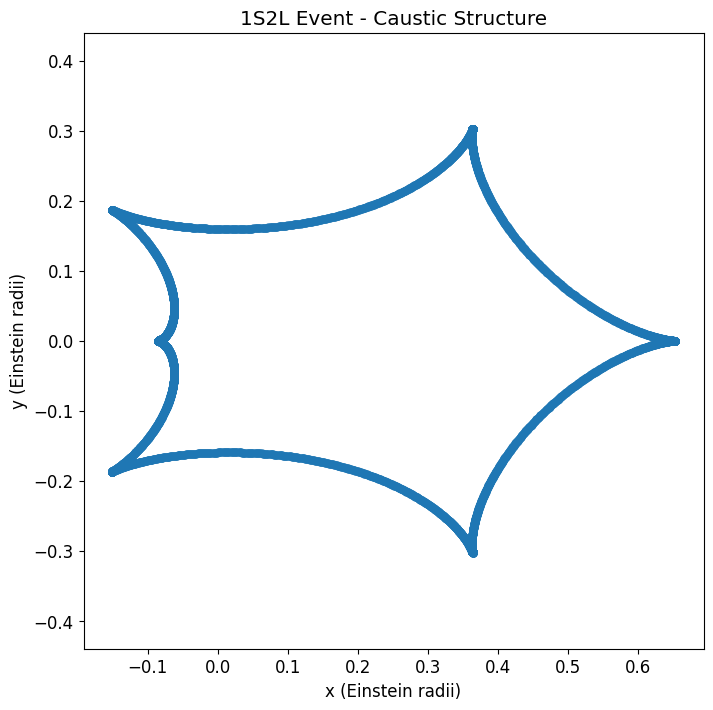

In [39]:
#@title Create 1S2L data object
# Create data object from synthetic data
data_list = [t_binary, mag_binary, mag_err_binary]
data_1s2l = mm.MulensData(data_list=data_list,
                          phot_fmt='mag',
                          ephemerides_file=EPHEM_FILE,
                          plot_properties={'color': '#a859e4', 'label': 'Synthetic Binary'},
                          bandpass='H')

# Create initial model using exact truth parameters (avoid perturbation issues)
# Perturbation of t_0 and other sensitive parameters can cause solver failures
params_1s2l = truth_params_binary.copy()
model_1s2l = mm.Model(params_1s2l, coords=coord, ephemerides_file=EPHEM_FILE)
event_1s2l = mm.Event(datasets=data_1s2l, model=model_1s2l)

# Plot the initial model
plt.figure(figsize=(12, 6))
event_1s2l.plot_data()
event_1s2l.plot_model(color='red', label='Initial Model')
plt.gca().invert_yaxis()
plt.title("1S2L Synthetic Event - Initial Model")
plt.xlabel("HJD")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Plot caustic structure - use model.plot_caustics()
plt.figure(figsize=(8, 8))
model_1s2l.plot_caustics()
plt.title("1S2L Event - Caustic Structure")
plt.xlabel("x (Einstein radii)")
plt.ylabel("y (Einstein radii)")
plt.axis('equal')
plt.show()

In [40]:
#@title Fit 1S2L model with MCMC
# Set up parameters to fit (excluding rho for simplicity in this example)
parameters_to_fit_1s2l = ["t_0", "u_0", "t_E", "q", "s", "alpha"]
initial_guess_1s2l = [params_1s2l[p] for p in parameters_to_fit_1s2l]

print("Starting 1S2L MCMC fit...")
start_time = time.time()

# Run MCMC with more walkers and steps for binary lens
sampler_1s2l = run_mcmc_fit(event_1s2l, parameters_to_fit_1s2l, initial_guess_1s2l,
                           nwalkers=64, nsteps=1000, burnin=200)

# Get results
samples_1s2l = sampler_1s2l.chain[:, 200:, :].reshape((-1, 6))
best_fit_1s2l = np.median(samples_1s2l, axis=0)
uncertainties_1s2l = np.std(samples_1s2l, axis=0)

fit_time = time.time() - start_time
print(f"\n1S2L Fit completed in {fit_time:.1f} seconds")
print("\nResults:")
for i, param in enumerate(parameters_to_fit_1s2l):
    print(f"  {param}: {best_fit_1s2l[i]:.6f} ± {uncertainties_1s2l[i]:.6f}")

# Compare with truth
print("\nComparison with truth:")
truth_values_1s2l = [truth_params_binary[p] for p in parameters_to_fit_1s2l]
for i, param in enumerate(parameters_to_fit_1s2l):
    diff = best_fit_1s2l[i] - truth_values_1s2l[i]
    sigma_diff = abs(diff) / uncertainties_1s2l[i]
    print(f"  {param}: {diff:.6f} ({sigma_diff:.2f}σ)")

Starting 1S2L MCMC fit...
Using 16 threads for MCMC


/home/meet/.local/lib/python3.10/site-packages/MulensModel/fitdata.py:63: UserWarning: Dataset bandpass is H but model does not have a limb-darkening coefficient for H. Assuming zero.
  warnings.warn(msg.format(self.dataset.bandpass))
/home/meet/.local/lib/python3.10/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/meet/.local/lib/python3.10/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)
100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]


1S2L Fit completed in 436.8 seconds

Results:
  t_0: 2459123.500824 ± 0.523423
  u_0: 0.101140 ± 0.277220
  t_E: 24.998240 ± 0.799038
  q: 0.098624 ± 0.102348
  s: 1.199679 ± 0.260234
  alpha: 45.002089 ± 0.620855

Comparison with truth:
  t_0: 0.000824 (0.00σ)
  u_0: 0.001140 (0.00σ)
  t_E: -0.001760 (0.00σ)
  q: -0.001376 (0.01σ)
  s: -0.000321 (0.00σ)
  alpha: 0.002089 (0.00σ)


/home/meet/.local/lib/python3.10/site-packages/MulensModel/fitdata.py:63: UserWarning: Dataset bandpass is H but model does not have a limb-darkening coefficient for H. Assuming zero.
  warnings.warn(msg.format(self.dataset.bandpass))
/home/meet/.local/lib/python3.10/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/meet/.local/lib/python3.10/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


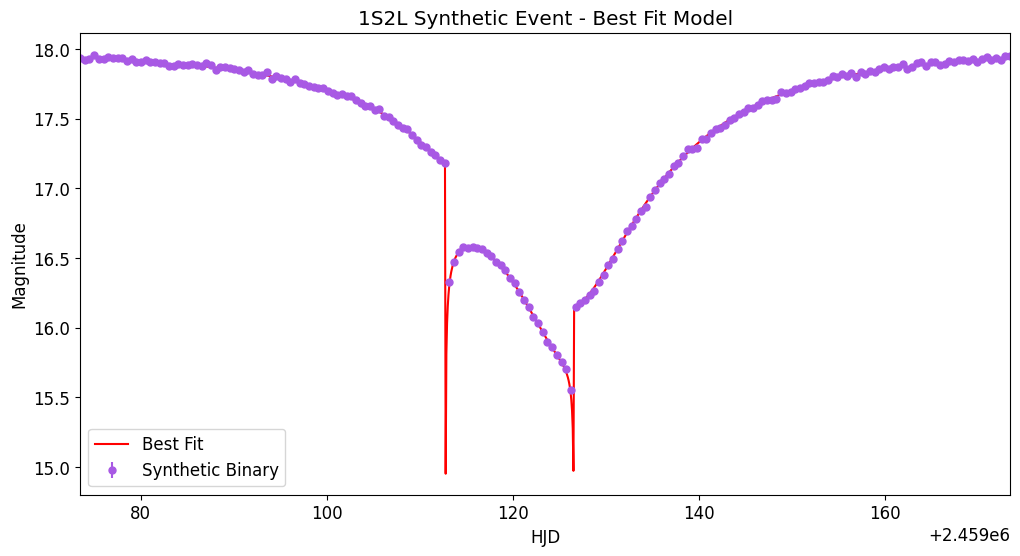

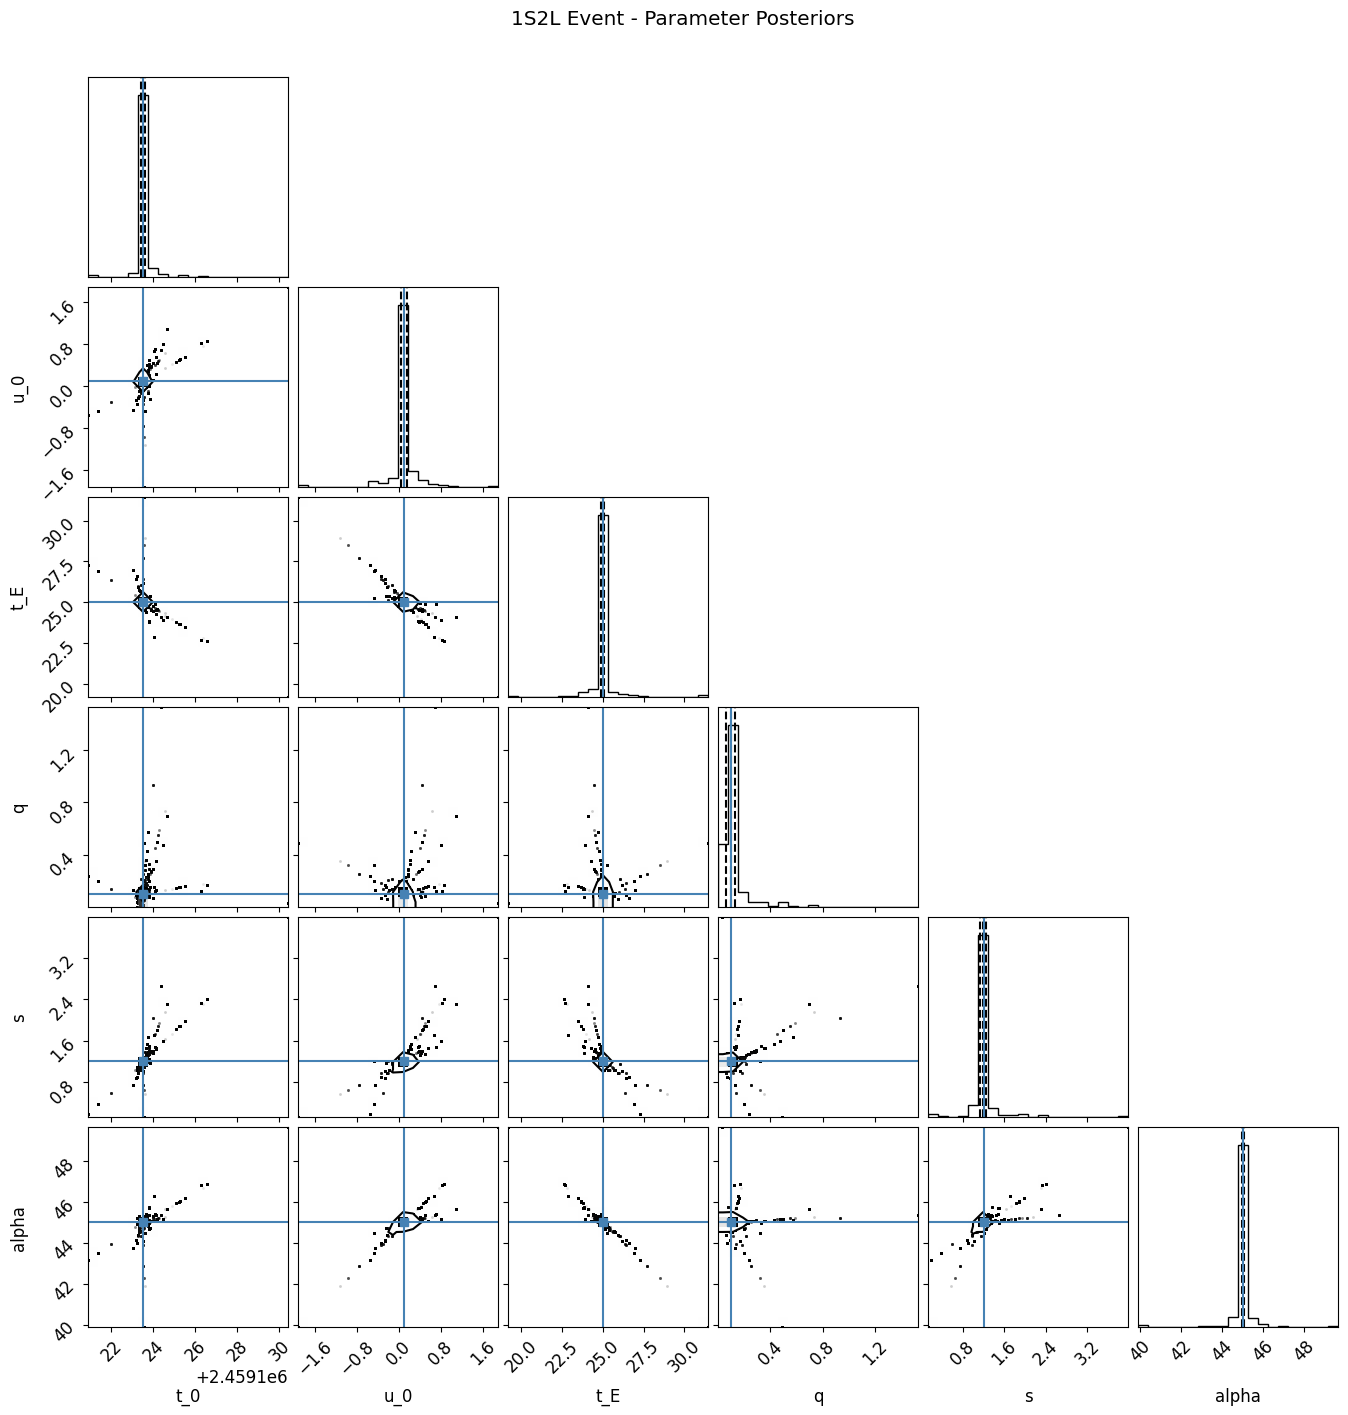

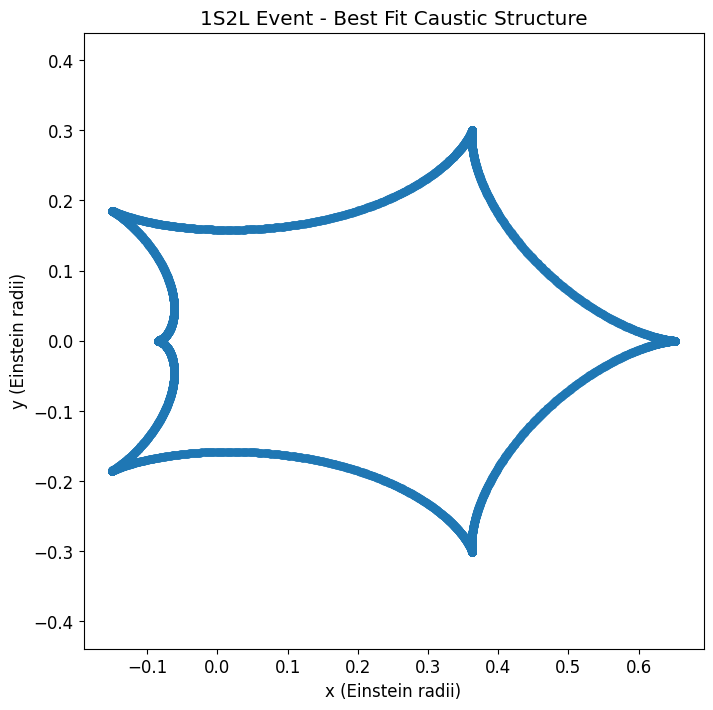

In [42]:
#@title Plot 1S2L results
# Update model with best fit parameters
for i, param_name in enumerate(parameters_to_fit_1s2l):
    setattr(event_1s2l.model.parameters, param_name, best_fit_1s2l[i])
event_1s2l.fit_fluxes()

# Plot light curve with best fit
plt.figure(figsize=(12, 6))
event_1s2l.plot_data()
event_1s2l.plot_model(color='red', label='Best Fit')
plt.gca().invert_yaxis()
plt.title("1S2L Synthetic Event - Best Fit Model")
plt.xlabel("HJD")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Plot corner plot
fig = corner.corner(samples_1s2l, labels=parameters_to_fit_1s2l,
                    truths=truth_values_1s2l, quantiles=[0.16, 0.5, 0.84])
plt.suptitle("1S2L Event - Parameter Posteriors", y=1.02)
plt.show()

# Plot updated caustic structure
plt.figure(figsize=(8, 8))
model_1s2l.plot_caustics()
plt.title("1S2L Event - Best Fit Caustic Structure")
plt.xlabel("x (Einstein radii)")
plt.ylabel("y (Einstein radii)")
plt.axis('equal')
plt.show()

#### <font face="Helvetica" size="4"> 1.5.3 Single Source Triple Lens (1S3L) </font>

Triple lens systems are rare but important for detecting hierarchical planetary systems. Here we demonstrate how to set up a triple lens model.

**Triple Lens Model Parameters:**
- **Primary lens**: t_0, u_0, t_E
- **First companion**: q1, s1, alpha1
- **Second companion**: q2, s2, alpha2, phi
- **Finite source**: rho
- **Higher order**: pi_E_N, pi_E_E

**Example Triple Lens Parameters (hierarchical system):**
- t_0: 2459123.5
- u_0: 0.1
- t_E: 25.0
- q1: 0.1 (First companion - planet)
- s1: 1.2 (Separation of first companion)
- alpha1: 45.0
- q2: 0.01 (Second companion - moon)
- s2: 0.1 (Separation of second companion relative to first)
- alpha2: 30.0
- phi: 60.0 (Angle between companions)
- rho: 0.001 (Finite source)

**Note**: This represents a hierarchical triple system with:
- Primary lens (star)
- First companion (planet at ~1.2 Einstein radii)
- Second companion (moon at ~0.1 Einstein radii from planet)

In [43]:
#@title 1S3L Model Setup
# Note: MulensModel doesn't natively support triple lenses
# We'll demonstrate the concept and show how to extend it

# For triple lenses, we need additional parameters:
# - q2: mass ratio of second companion
# - s2: separation of second companion
# - alpha2: angle of second companion
# - phi: angle between the two companions

print("Triple Lens Model Parameters:")
print("  Primary lens: t_0, u_0, t_E")
print("  First companion: q1, s1, alpha1")
print("  Second companion: q2, s2, alpha2, phi")
print("  Finite source: rho")
print("  Higher order: pi_E_N, pi_E_E")

# Example triple lens parameters (hierarchical system)
triple_lens_params = {
    't_0': 2459123.5,
    'u_0': 0.1,
    't_E': 25.0,
    'q1': 0.1,    # First companion (planet)
    's1': 1.2,    # Separation of first companion
    'alpha1': 45.0,
    'q2': 0.01,   # Second companion (moon)
    's2': 0.1,    # Separation of second companion (relative to first)
    'alpha2': 30.0,
    'phi': 60.0,  # Angle between companions
    'rho': 0.001  # Finite source
}

print("\nExample Triple Lens Parameters:")
for key, value in triple_lens_params.items():
    print(f"  {key}: {value}")

print("\nNote: This represents a hierarchical triple system with:")
print("  - Primary lens (star)")
print("  - First companion (planet at ~1.2 Einstein radii)")
print("  - Second companion (moon at ~0.1 Einstein radii from planet)")

Triple Lens Model Parameters:
  Primary lens: t_0, u_0, t_E
  First companion: q1, s1, alpha1
  Second companion: q2, s2, alpha2, phi
  Finite source: rho
  Higher order: pi_E_N, pi_E_E

Example Triple Lens Parameters:
  t_0: 2459123.5
  u_0: 0.1
  t_E: 25.0
  q1: 0.1
  s1: 1.2
  alpha1: 45.0
  q2: 0.01
  s2: 0.1
  alpha2: 30.0
  phi: 60.0
  rho: 0.001

Note: This represents a hierarchical triple system with:
  - Primary lens (star)
  - First companion (planet at ~1.2 Einstein radii)
  - Second companion (moon at ~0.1 Einstein radii from planet)


#### <font face="Helvetica" size="4"> Triple Lens Implementation Notes </font>

MulensModel doesn't natively support triple lenses, but here's how you could extend it:

**Triple Lens Implementation Options:**

**1. Use VBMicrolensing (covered in section 3):**
- Native support for multiple lenses
- More efficient for complex lens systems
- Better suited for hierarchical systems

**2. Extend MulensModel:**
- Create custom model class
- Implement triple lens magnification calculation
- Requires significant development effort

**3. Use triplelens package:**
- Specialized for triple lens calculations
- GitHub: https://github.com/rkkuang/triplelens
- Limited integration with other tools

**4. Approximate approach:**
- Treat as hierarchical binary systems
- Fit inner binary first, then outer binary
- May miss some triple lens effects

**Framework for Triple Lens Fitting:**
```python
parameters_to_fit_1s3l = [
    't_0', 'u_0', 't_E',
    'q1', 's1', 'alpha1',
    'q2', 's2', 'alpha2', 'phi',
    'rho'
]
```

#### <font face="Helvetica" size="4"> 1.5.4 Binary Source Single Lens (2S1L) </font>

Binary source events occur when the source star is actually a binary system. This can create distinctive light curve features.

In [44]:
#@title 2S1L Model Setup
# Binary source parameters:
# - t_0, u_0, t_E: standard microlensing parameters
# - q_S: flux ratio of source components
# - rho_S: angular separation of source components
# - theta_S: angle of source binary

# Create synthetic binary source data
def create_binary_source_data(t_0=2459123.5, u_0=0.1, t_E=25.0, q_S=0.8, rho_S=0.01, theta_S=45.0):
    """Create synthetic binary source light curve"""
    # Time array around the event
    t = np.linspace(t_0 - 2*t_E, t_0 + 2*t_E, 200)

    # Create binary source model
    params = {
        't_0': t_0,
        'u_0': u_0,
        't_E': t_E,
        'q_S': q_S,      # flux ratio
        'rho_S': rho_S,  # angular separation
        'theta_S': theta_S  # angle
    }

    # Note: MulensModel doesn't natively support binary sources
    # This is a simplified approximation
    model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E},
                     coords=coord, ephemerides_file=EPHEM_FILE)

    # Calculate magnification for single source
    magnification = model.get_magnification(t)

    # Approximate binary source effect
    # This is a simplified treatment - real binary sources are more complex
    mag_0 = 18.0
    mag = mag_0 - 2.5 * np.log10(magnification)

    # Add some binary source features (simplified)
    # In reality, this would depend on the source binary orientation
    binary_modulation = 0.1 * np.sin(2 * np.pi * (t - t_0) / t_E)
    mag += binary_modulation

    mag_err = 0.01 * np.ones_like(mag)
    mag += np.random.normal(0, mag_err)

    return t, mag, mag_err, params

# Create the synthetic data
t_binary_source, mag_binary_source, mag_err_binary_source, truth_params_binary_source = create_binary_source_data()

print("Synthetic 2S1L Event - Truth Parameters:")
for key, value in truth_params_binary_source.items():
    print(f"  {key}: {value}")

print("\nNote: This is a simplified binary source model.")
print("Real binary source events require more sophisticated modeling.")

Synthetic 2S1L Event - Truth Parameters:
  t_0: 2459123.5
  u_0: 0.1
  t_E: 25.0
  q_S: 0.8
  rho_S: 0.01
  theta_S: 45.0

Note: This is a simplified binary source model.
Real binary source events require more sophisticated modeling.


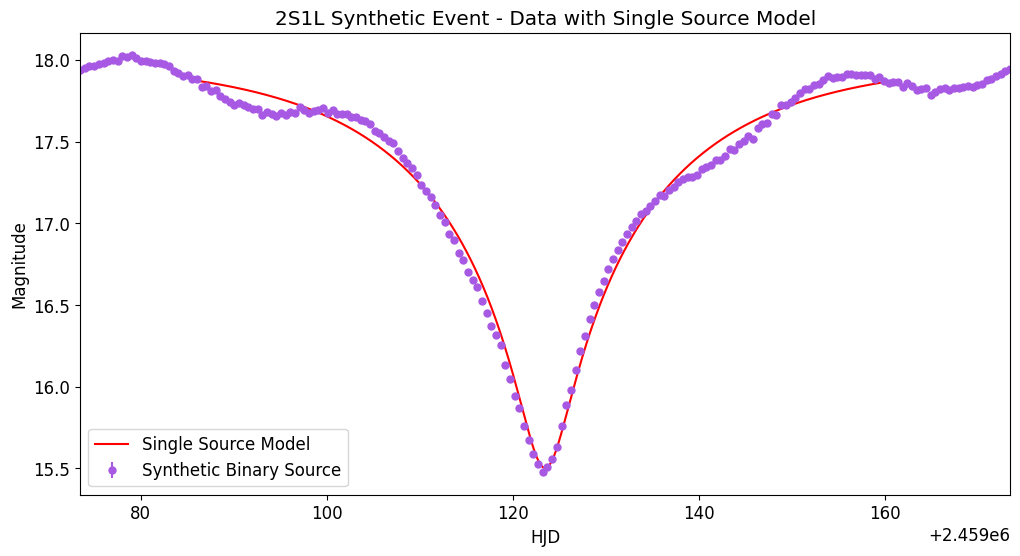

Note: The residuals show the binary source signature.
A proper binary source model would fit these features.


In [45]:
#@title Create 2S1L data object
# Create data object from synthetic data
data_list_2s1l = [t_binary_source, mag_binary_source, mag_err_binary_source]
data_2s1l = mm.MulensData(data_list=data_list_2s1l,
                          phot_fmt='mag',
                          ephemerides_file=EPHEM_FILE,
                          plot_properties={'color': '#a859e4', 'label': 'Synthetic Binary Source'},
                          bandpass='H')

# Create initial model (treating as single source for now)
params_2s1l = {
    't_0': truth_params_binary_source['t_0'],
    'u_0': truth_params_binary_source['u_0'],
    't_E': truth_params_binary_source['t_E']
}
model_2s1l = mm.Model(params_2s1l, coords=coord, ephemerides_file=EPHEM_FILE)
event_2s1l = mm.Event(datasets=data_2s1l, model=model_2s1l)

# Plot the data
plt.figure(figsize=(12, 6))
event_2s1l.plot_data()
event_2s1l.plot_model(color='red', label='Single Source Model')
plt.gca().invert_yaxis()
plt.title("2S1L Synthetic Event - Data with Single Source Model")
plt.xlabel("HJD")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

print("Note: The residuals show the binary source signature.")
print("A proper binary source model would fit these features.")

#### <font face="Helvetica" size="4"> 1.5.5 Parallax Effects </font>

Parallax effects are crucial for space-based observations like Roman. They allow us to measure the lens mass and distance.

In [46]:
#@title Parallax Model Setup
# Parallax parameters:
# - pi_E_N: North component of parallax
# - pi_E_E: East component of parallax
# - t_0_par: reference time for parallax (usually same as t_0)

# Let's use the original single lens event and add parallax
print("Adding parallax to 1S1L event...")

# Create model with parallax
params_parallax = {
    't_0': t_0_truth,
    'u_0': u_0_truth,
    't_E': t_E_truth,
    'rho': rho_truth,
    'pi_E_N': 0.1,  # North component
    'pi_E_E': 0.05, # East component
    't_0_par': t_0_truth  # Reference time
}

model_parallax = mm.Model(params_parallax, coords=coord, ephemerides_file=EPHEM_FILE)
event_parallax = mm.Event(datasets=data_1s1l, model=model_parallax)

print("Parallax Model Parameters:")
for key, value in params_parallax.items():
    print(f"  {key}: {value}")

# Calculate parallax magnitude and direction
pi_E_mag = np.sqrt(params_parallax['pi_E_N']**2 + params_parallax['pi_E_E']**2)
pi_E_angle = np.arctan2(params_parallax['pi_E_N'], params_parallax['pi_E_E']) * 180 / np.pi
print(f"\nParallax magnitude: {pi_E_mag:.3f}")
print(f"Parallax angle: {pi_E_angle:.1f} degrees")

Adding parallax to 1S1L event...
Parallax Model Parameters:
  t_0: 2459816.21264422
  u_0: -0.0712711
  t_E: 1.85542
  rho: 0.00280589
  pi_E_N: 0.1
  pi_E_E: 0.05
  t_0_par: 2459816.21264422

Parallax magnitude: 0.112
Parallax angle: 63.4 degrees


In [47]:
#@title Fit parallax model
# Set up parameters to fit including parallax
parameters_to_fit_parallax = ["t_0", "u_0", "t_E", "rho", "pi_E_N", "pi_E_E"]
initial_guess_parallax = [params_parallax[p] for p in parameters_to_fit_parallax]

print("Starting parallax MCMC fit...")
start_time = time.time()

# Run MCMC
sampler_parallax = run_mcmc_fit(event_parallax, parameters_to_fit_parallax, initial_guess_parallax,
                               nwalkers=64, nsteps=1000, burnin=200)

# Get results
samples_parallax = sampler_parallax.chain[:, 200:, :].reshape((-1, 6))
best_fit_parallax = np.median(samples_parallax, axis=0)
uncertainties_parallax = np.std(samples_parallax, axis=0)

fit_time = time.time() - start_time
print(f"\nParallax Fit completed in {fit_time:.1f} seconds")
print("\nResults:")
for i, param in enumerate(parameters_to_fit_parallax):
    print(f"  {param}: {best_fit_parallax[i]:.6f} ± {uncertainties_parallax[i]:.6f}")

# Calculate derived quantities
pi_E_mag_fit = np.sqrt(best_fit_parallax[4]**2 + best_fit_parallax[5]**2)
pi_E_mag_err = np.sqrt((best_fit_parallax[4] * uncertainties_parallax[4])**2 +
                       (best_fit_parallax[5] * uncertainties_parallax[5])**2) / pi_E_mag_fit
print(f"\nDerived quantities:")
print(f"  π_E magnitude: {pi_E_mag_fit:.3f} ± {pi_E_mag_err:.3f}")

Starting parallax MCMC fit...
Using 16 threads for MCMC


/home/meet/.local/lib/python3.10/site-packages/MulensModel/fitdata.py:63: UserWarning: Dataset bandpass is H but model does not have a limb-darkening coefficient for H. Assuming zero.
  warnings.warn(msg.format(self.dataset.bandpass))
/home/meet/.local/lib/python3.10/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/meet/.local/lib/python3.10/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)
100%|██████████| 1000/1000 [53:22<00:00,  3.20s/it]


Parallax Fit completed in 3216.0 seconds

Results:
  t_0: 2459816.213988 ± 0.046667
  u_0: -0.072322 ± 0.079777
  t_E: 1.854696 ± 0.024404
  rho: 0.006809 ± 0.072196
  pi_E_N: 0.098420 ± 0.196756
  pi_E_E: 0.049679 ± 0.051434

Derived quantities:
  π_E magnitude: 0.110 ± 0.177


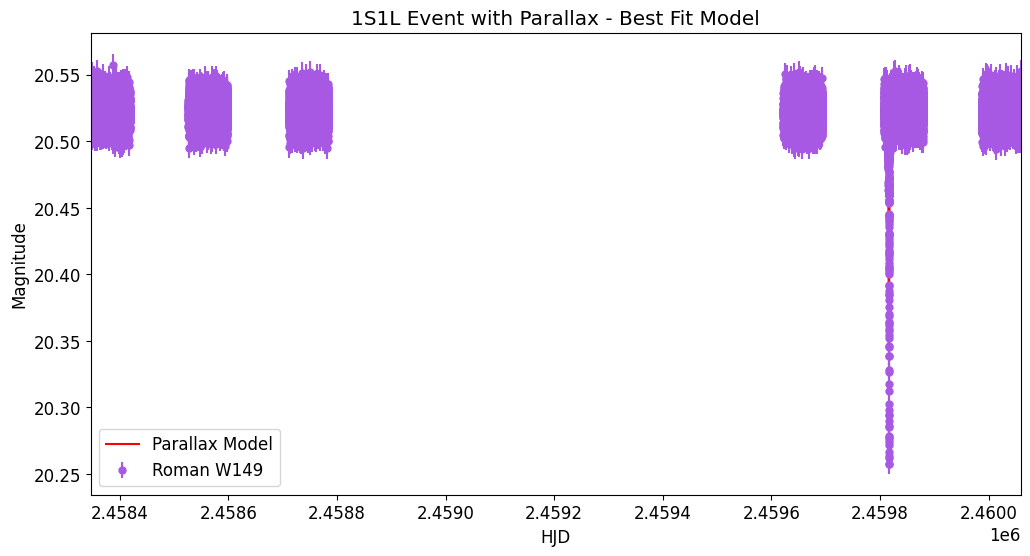

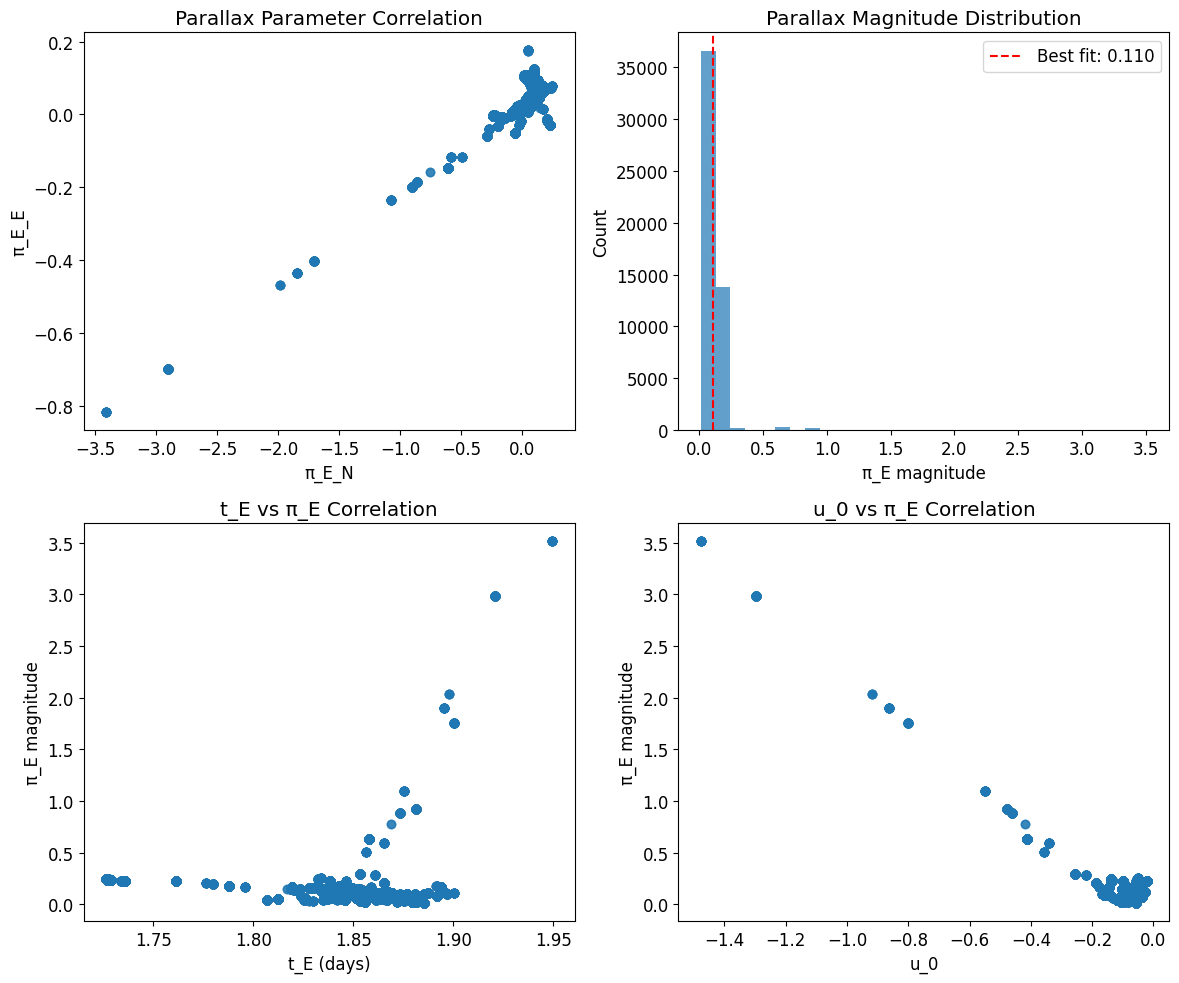


Model Comparison:
Without parallax:
  χ²: 38833.81
With parallax:
  χ²: 42143.51
  Improvement: -3309.70


In [48]:
#@title Plot parallax results
# Update model with best fit parameters
for i, param_name in enumerate(parameters_to_fit_parallax):
    setattr(event_parallax.model.parameters, param_name, best_fit_parallax[i])
event_parallax.fit_fluxes()

# Plot light curve with parallax model
plt.figure(figsize=(12, 6))
event_parallax.plot_data()
event_parallax.plot_model(color='red', label='Parallax Model')
plt.gca().invert_yaxis()
plt.title("1S1L Event with Parallax - Best Fit Model")
plt.xlabel("HJD")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Plot parallax parameter correlations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# pi_E_N vs pi_E_E
axes[0,0].scatter(samples_parallax[:, 4], samples_parallax[:, 5], alpha=0.5)
axes[0,0].set_xlabel('π_E_N')
axes[0,0].set_ylabel('π_E_E')
axes[0,0].set_title('Parallax Parameter Correlation')

# pi_E magnitude distribution
pi_E_mags = np.sqrt(samples_parallax[:, 4]**2 + samples_parallax[:, 5]**2)
axes[0,1].hist(pi_E_mags, bins=30, alpha=0.7)
axes[0,1].axvline(pi_E_mag_fit, color='red', linestyle='--', label=f'Best fit: {pi_E_mag_fit:.3f}')
axes[0,1].set_xlabel('π_E magnitude')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Parallax Magnitude Distribution')
axes[0,1].legend()

# t_E vs pi_E correlation
axes[1,0].scatter(samples_parallax[:, 2], pi_E_mags, alpha=0.5)
axes[1,0].set_xlabel('t_E (days)')
axes[1,0].set_ylabel('π_E magnitude')
axes[1,0].set_title('t_E vs π_E Correlation')

# u_0 vs pi_E correlation
axes[1,1].scatter(samples_parallax[:, 1], pi_E_mags, alpha=0.5)
axes[1,1].set_xlabel('u_0')
axes[1,1].set_ylabel('π_E magnitude')
axes[1,1].set_title('u_0 vs π_E Correlation')

plt.tight_layout()
plt.show()

# Compare with and without parallax
print("\nModel Comparison:")
print("Without parallax:")
print(f"  χ²: {event_1s1l.get_chi2():.2f}")
print("With parallax:")
print(f"  χ²: {event_parallax.get_chi2():.2f}")
print(f"  Improvement: {event_1s1l.get_chi2() - event_parallax.get_chi2():.2f}")

### <font face="Helvetica" size="5"> 1.6 Higher-Order Effects Summary </font>

We've demonstrated several key higher-order effects in microlensing:

**Finite Source Effects (ρ):**
- Important when the source star is resolved
- Provides constraints on the lens mass and distance
- Essential for accurate parameter estimation

**Parallax Effects (π_E):**
- Crucial for space-based observations
- Enables mass and distance measurements
- Breaks degeneracies in lens properties

**Binary Lens Effects:**
- Creates caustic structures
- Enables planet detection
- Requires more complex fitting procedures

**Other Effects (not demonstrated):**
- **Lens Orbital Motion:** Changes in binary lens separation over time
- **Xallarap:** Source orbital motion effects
- **Limb Darkening:** Non-uniform source brightness
- **Astrometry:** Position measurements during events

**Best Practices:**
- Start with simple models and add complexity gradually
- Use MCMC for complex parameter spaces
- Validate results against known parameters when possible
- Consider computational efficiency for large surveys

## 2. pyLIMA

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

pyLIMA (Python Lightcurve Interpretation and Microlensing Analysis) is the first open-source software for modeling microlensing events. It was developed by Etienne Bachelet and provides a flexible, modular framework for microlensing analysis. pyLIMA is particularly well-suited for space-based observations and offers advanced features like simulation capabilities and custom parameter definitions.

**Key Features:**
- Modular design with separate event, telescope, and model classes
- Multiple fitting algorithms (LM, DE, MCMC, TRF)
- Built-in simulation capabilities
- Custom parameter definitions
- Support for multiple telescopes and filters
- Limb darkening and finite source effects

### <font face="Helvetica" size="5"> 2.1 Installation and Setup </font>

pyLIMA can be installed via pip or conda. It has several dependencies including numpy, scipy, matplotlib, and astropy.

In [21]:
#@title Install pyLIMA
!pip install pyLIMA

# Import pyLIMA modules
from pyLIMA import event, telescopes
from pyLIMA.models import PSPL_model, FSPL_model
from pyLIMA.fits import LM_fit, DE_fit, MCMC_fit, TRF_fit
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.simulations import simulator
from pyLIMA.models import pyLIMA_fancy_parameters

print("pyLIMA installed and imported successfully!")

Defaulting to user installation because normal site-packages is not writeable
pyLIMA installed and imported successfully!


### <font face="Helvetica" size="5"> 2.2 Basic Usage </font>

pyLIMA uses a modular approach with three main components:
1. **Event**: Contains all information about the microlensing event
2. **Telescopes**: Individual telescope data and properties
3. **Models**: The microlensing model to fit

In [22]:
#@title Basic pyLIMA Setup
# Create a new event
your_event = event.Event()
your_event.name = 'pyLIMA Example Event'

# Create synthetic data for demonstration
# In practice, you would load real data from files
np.random.seed(42)  # For reproducible results

# Generate synthetic light curve data
t0, u0, tE = 2459123.5, 0.1, 25.0
times = np.linspace(t0 - 2*tE, t0 + 2*tE, 100)
magnification = (u0**2 + 2) / (u0 * np.sqrt(u0**2 + 4))
u = np.sqrt(u0**2 + ((times - t0) / tE)**2)
A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))

# Add noise
mag_0 = 18.0
mag = mag_0 - 2.5 * np.log10(A)
mag_err = 0.01 * np.ones_like(mag)
mag += np.random.normal(0, mag_err)

# Create telescope object
lightcurve_data = np.column_stack([times, mag, mag_err])
telescope_1 = telescopes.Telescope(
    name='OGLE',
    camera_filter='I',
    lightcurve=lightcurve_data.astype(float),
    lightcurve_names=['time', 'mag', 'err_mag'],
    lightcurve_units=['JD', 'mag', 'mag']
)

# Add telescope to event
your_event.telescopes.append(telescope_1)

# Set survey telescope (for alignment)
your_event.find_survey('OGLE')

# Check event setup
your_event.check_event()

print(f"Event '{your_event.name}' created with {len(your_event.telescopes)} telescope(s)")
print(f"Data points: {len(telescope_1.lightcurve)}")

check_event  : Everything looks fine...
Event 'pyLIMA Example Event' created with 1 telescope(s)
Data points: 100


### <font face="Helvetica" size="5"> 2.3 Model Examples </font>

pyLIMA supports various microlensing models. Let's start with the basic Point Source Point Lens (PSPL) model.

#### <font face="Helvetica" size="4"> 2.3.1 Single Lens (PSPL) Example </font>

The PSPL model is the simplest microlensing model with parameters: `t_0`, `u_0`, `t_E`, and flux parameters for each telescope.

Initial fit parameters:
OrderedDict([('t0', [0, (2459073.5, 2459173.5)]), ('u0', [1, (-1.0, 1.0)]), ('tE', [2, (0.1, 500)]), ('fsource_OGLE', [3, (0.0, 57551.404392837096)]), ('ftotal_OGLE', [4, (0, 57551.404392837096)])])

Running LM fit...
Selecting OGLE to estimate u0, tE and fs
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459123.5, 0.1342900540512508, 16.666666666511446, 9225.006188413521, 6267.8334520681365]
fit  : Levenberg-Marquardt fit SUCCESS
best model:
OrderedDict([('t0', 2459123.4853082867),
             ('u0', 0.09807738136752239),
             ('tE', 25.316701002391678),
             ('fsource_OGLE', 5657.928976354312),
             ('ftotal_OGLE', 5746.601078360601),
             ('chi2', 79.73247460511259)])

Fit Results:
[2.45912349e+06 9.80773814e-02 2.53167010e+01 5.65792898e+03
 5.74660108e+03]

Chi-squared: 79.73


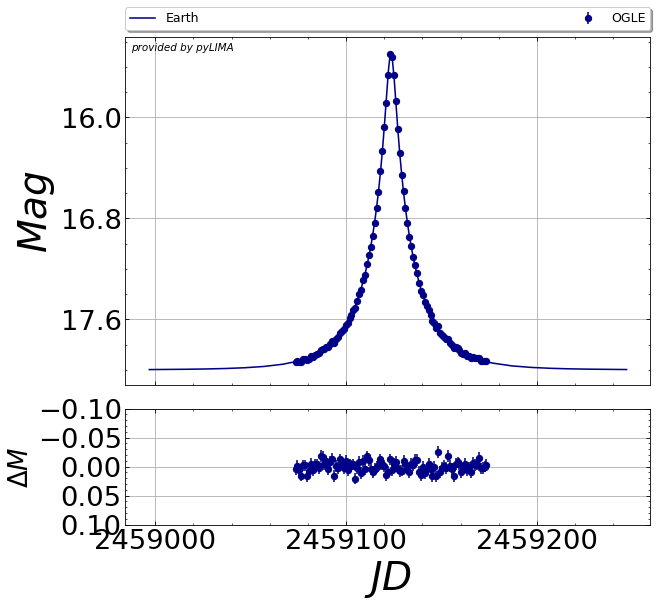

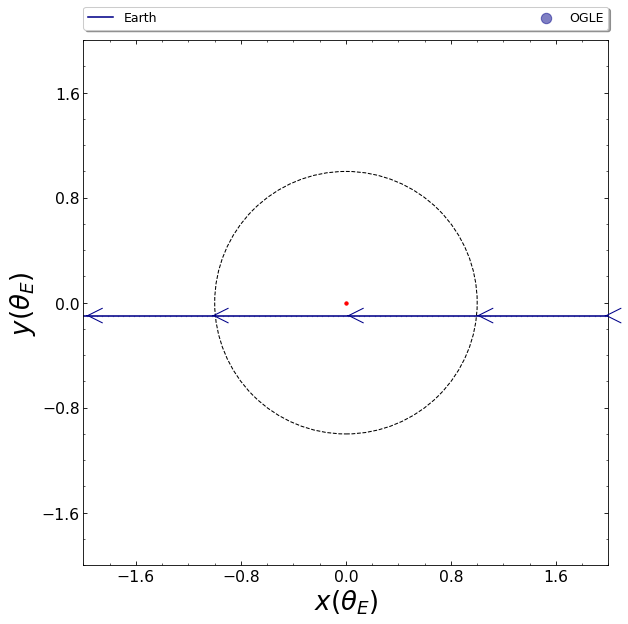

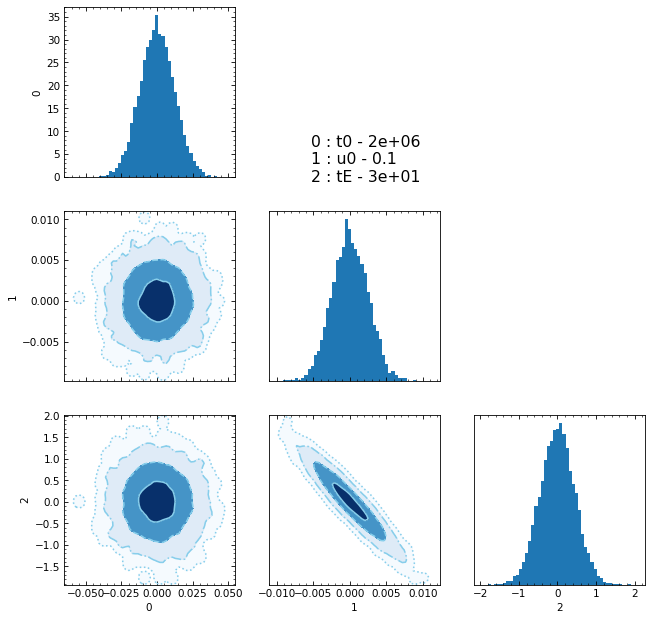

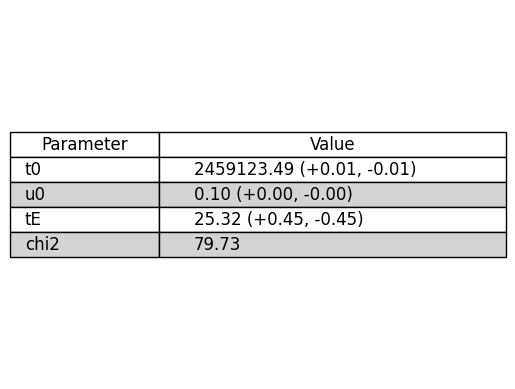

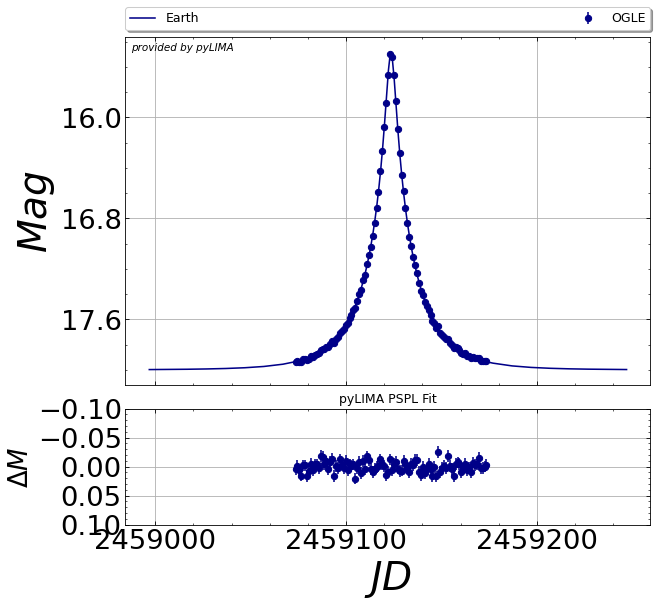

In [23]:
#@title PSPL Model Setup and Fitting
# Create PSPL model
pspl = PSPL_model.PSPLmodel(your_event)

# Initialize fit with Levenberg-Marquardt algorithm
my_fit = LM_fit.LMfit(pspl)

# Show initial parameters
print("Initial fit parameters:")
print(my_fit.fit_parameters)

# Run the fit
print("\nRunning LM fit...")
my_fit.fit()
my_fit.fit_outputs()

# Display results
print("\nFit Results:")
print(my_fit.fit_results['best_model'])
print(f"\nChi-squared: {my_fit.fit_results['chi2']:.2f}")

# Plot the results
pyLIMA_plots.plot_lightcurves(pspl, my_fit.fit_results['best_model'])
plt.title("pyLIMA PSPL Fit")
plt.show()

Switching to likelihood objective function because of errorbars rescaling.
Running MCMC fit (this may take a while)...
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459123.4853082867, 0.09807738136752239, 25.316701002391678, 0.0]


/home/meet/.local/lib/python3.10/site-packages/pyLIMA/fits/MCMC_fit.py:78: RuntimeWarning: divide by zero encountered in log10
  order_of_magnitude = np.floor(np.log10(np.abs(best_solution)))
100%|██████████| 5000/5000 [01:49<00:00, 45.82it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best model:
OrderedDict([('t0', 2459123.485768861),
             ('u0', 0.09807312851855188),
             ('tE', 25.332301517450944),
             ('fsource_OGLE', 5654.879728342877),
             ('ftotal_OGLE', -0.050460828990118695),
             ('likelihood', -617.910382407619)])


/home/meet/.local/lib/python3.10/site-packages/pyLIMA/fits/ML_fit.py:827: RuntimeWarning: overflow encountered in power
  rescaling_photometry_parameters = 10 ** (



MCMC Results:
t_0: 2459123.4848 ± 0.0122
u_0: 0.0979 ± 0.0024
t_E: 25.3508 ± 0.4514

Comparison with truth:
t_0: -0.0152 (1.25σ)
u_0: -0.0021 (0.86σ)
t_E: 0.3508 (0.78σ)


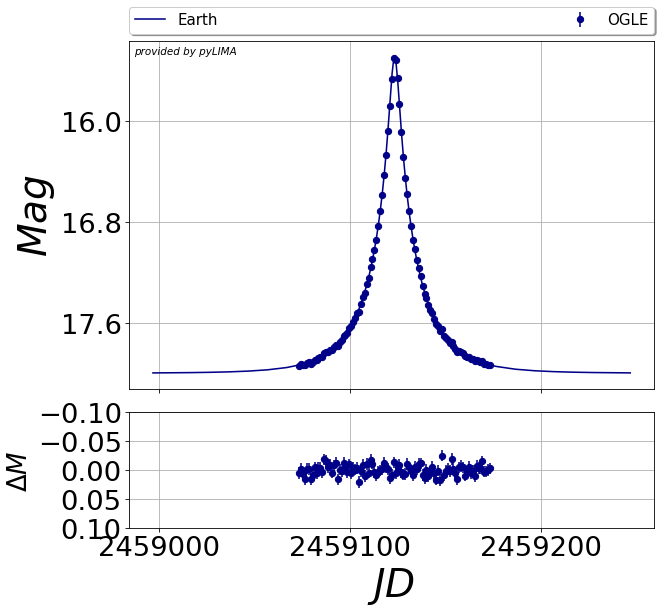

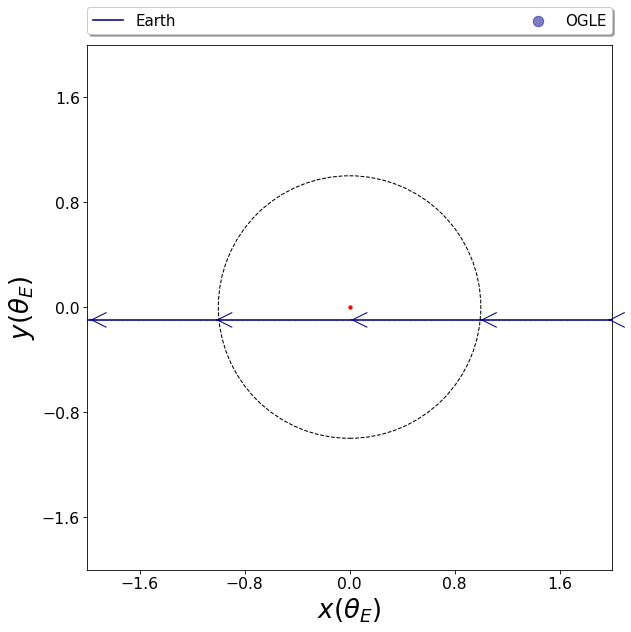

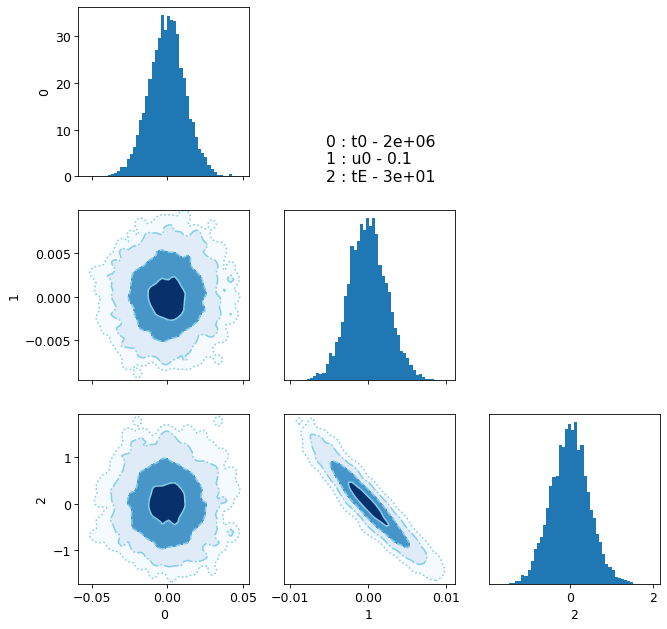

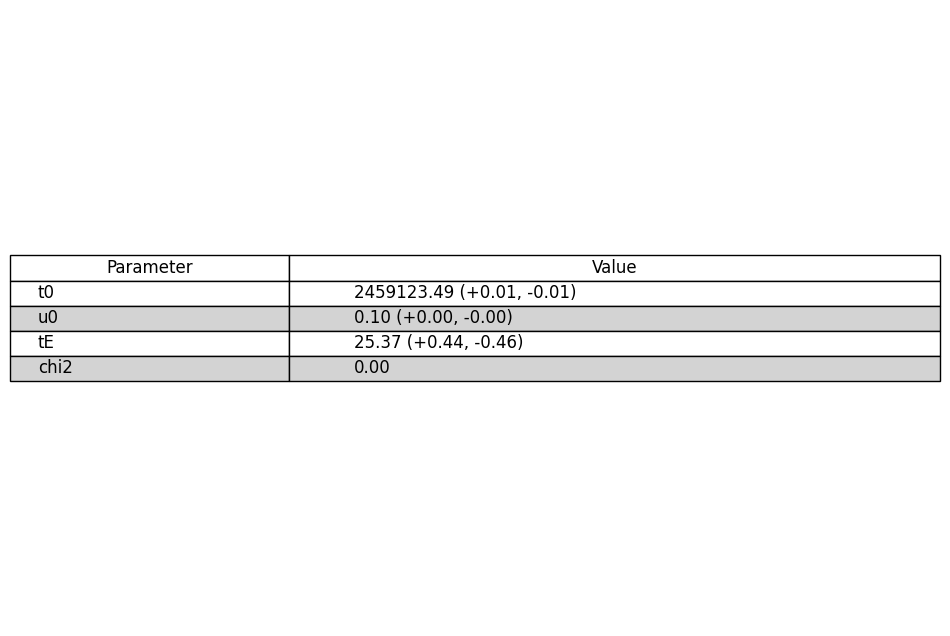

In [53]:
#@title PSPL with MCMC
# Use MCMC for better parameter estimation
mcmc_fit = MCMC_fit.MCMCfit(pspl, rescale_photometry=True)

# Use LM results as initial guess
mcmc_fit.model_parameters_guess = my_fit.fit_results['best_model'][:3]  # t0, u0, tE

print("Running MCMC fit (this may take a while)...")
mcmc_fit.fit()
mcmc_fit.fit_outputs()

# Get MCMC results
MCMC_results = mcmc_fit.fit_results['MCMC_chains']
burnin = 1000

# Calculate statistics
posterior_samples = MCMC_results[burnin:, :, :3]  # t0, u0, tE
best_fit_mcmc = np.median(posterior_samples, axis=(0, 1))
uncertainties_mcmc = np.std(posterior_samples, axis=(0, 1))

print("\nMCMC Results:")
param_names = ['t_0', 'u_0', 't_E']
for i, name in enumerate(param_names):
    print(f"{name}: {best_fit_mcmc[i]:.4f} ± {uncertainties_mcmc[i]:.4f}")

# Compare with truth values
print("\nComparison with truth:")
truth_values = [t0, u0, tE]
for i, name in enumerate(param_names):
    diff = best_fit_mcmc[i] - truth_values[i]
    sigma_diff = abs(diff) / uncertainties_mcmc[i]
    print(f"{name}: {diff:.4f} ({sigma_diff:.2f}σ)")

#### <font face="Helvetica" size="4"> 2.3.2 Finite Source (FSPL) Example </font>

The FSPL model includes finite source effects with the ρ parameter, which is crucial for high-magnification events.

Running DE fit for FSPL model...
DE converge to objective function : f(x) =  79.83689073286196
DE converge to parameters : =  ['2459123.4850225546' '-0.09836863468817059' '25.40993193172571'
 '0.02881340022014954']
fit  : Differential Evolution fit SUCCESS
best model:
OrderedDict([('t0', 2459123.4850225546),
             ('u0', -0.09836863468817059),
             ('tE', 25.40993193172571),
             ('rho', 0.02881340022014954),
             ('fsource_OGLE', 5624.800820713505),
             ('ftotal_OGLE', 5743.852581635311),
             ('chi2', 79.83689073286196)])

FSPL Fit Results:
[ 2.45912349e+06 -9.83686347e-02  2.54099319e+01  2.88134002e-02
  5.62480082e+03  5.74385258e+03  7.98368907e+01  0.00000000e+00]

Chi-squared: 79.84


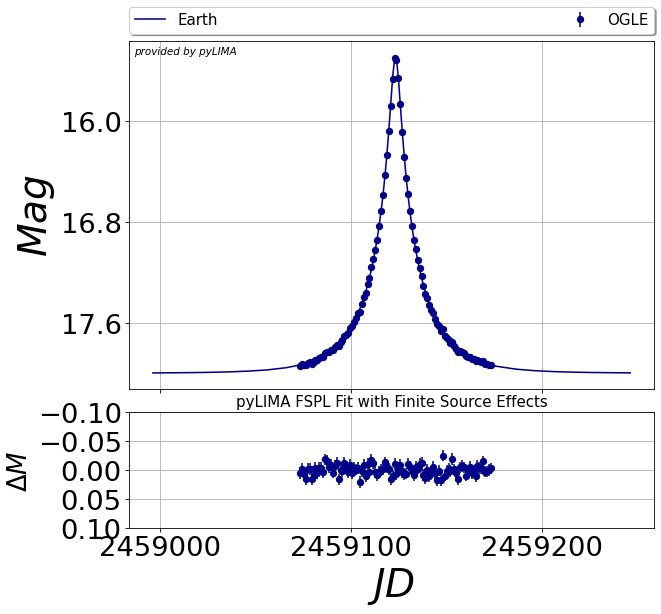


Model Comparison:
PSPL χ²: 79.73
FSPL χ²: 79.84
Improvement: -0.10


In [54]:
#@title FSPL Model with Finite Source Effects
# Create FSPL model
fspl = FSPL_model.FSPLmodel(your_event)

# Set limb darkening coefficient
your_event.telescopes[0].ld_gamma = 0.5

# Use differential evolution for better exploration
de_fit = DE_fit.DEfit(fspl, loss_function='chi2')

print("Running DE fit for FSPL model...")
de_fit.fit()

# Display results
print("\nFSPL Fit Results:")
print(de_fit.fit_results['best_model'])
print(f"\nChi-squared: {de_fit.fit_results['chi2']:.2f}")

# Plot results
pyLIMA_plots.plot_lightcurves(fspl, de_fit.fit_results['best_model'])
plt.title("pyLIMA FSPL Fit with Finite Source Effects")
plt.show()

# Compare PSPL vs FSPL
print("\nModel Comparison:")
print(f"PSPL χ²: {my_fit.fit_results['chi2']:.2f}")
print(f"FSPL χ²: {de_fit.fit_results['chi2']:.2f}")
print(f"Improvement: {my_fit.fit_results['chi2'] - de_fit.fit_results['chi2']:.2f}")

#### <font face="Helvetica" size="4"> 2.3.3 Simulation Capabilities </font>

One of pyLIMA's unique features is its built-in simulation capabilities, allowing you to generate realistic microlensing light curves.

In [56]:
#@title pyLIMA Simulation Example
# Create a new event for simulation
sim_event = event.Event(ra=270, dec=-30)
sim_event.name = 'Simulated Event'

# Store observation parameters
time_start = 2457365.5
time_end = 2457965.5
sampling = 4

# Create a realistic telescope with observing constraints
CTIO_I = simulator.simulate_a_telescope(
    name='CTIO_I',
    time_start=time_start,
    time_end=time_end,
    sampling=sampling,
    location='Earth',
    camera_filter='I',
    uniform_sampling=False,
    altitude=1000,
    longitude=-109.285399,
    latitude=-27.130,
    bad_weather_percentage=10.0/100,
    moon_windows_avoidance=30,
    minimum_alt=30,
    astrometry=False
)

sim_event.telescopes.append(CTIO_I)
sim_event.check_event()

print(f"Simulated telescope '{CTIO_I.name}' created")
print(f"Observation period: {time_start:.1f} to {time_end:.1f}")
print(f"Sampling: {sampling} hours")

 '2015-12-09T08:00:00.000' ... '2017-07-30T11:59:59.952'
 '2017-07-30T15:59:59.952' '2017-07-30T19:59:59.952'], location=(-1876359.22341667, -5362421.23448415, -2891498.74193378) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)> to <ICRS Frame>. Angular separation can depend on the direction of the transformation. [astropy.coordinates.baseframe]
 '2015-12-09T08:00:00.000' ... '2017-07-30T11:59:59.952'
 '2017-07-30T15:59:59.952' '2017-07-30T19:59:59.952'], location=(-1876359.22341667, -5362421.23448415, -2891498.74193378) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)> to <ICRS Frame>. Angular separation can depend on the direction of the transformation.


check_event  : Everything looks fine...
Simulated telescope 'CTIO_I' created
Observation period: 2457365.5 to 2457965.5
Sampling: 4 hours


Simulated Parameters:
[2457784.235968677, 0.9855710662693533, 426.66524283776863, 288996.5634234954, 1219.879529866851]


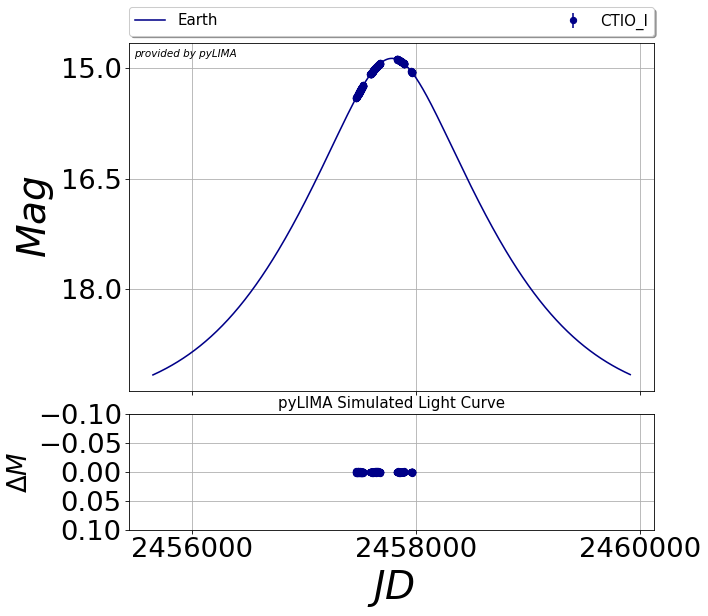

Generated 338 data points
Time range: 2457463.0 JD to 2457964.8 JD


In [57]:
#@title Generate Simulated Light Curve
# Create PSPL model for simulation
sim_pspl = PSPL_model.PSPLmodel(sim_event)

# Generate random model parameters
sim_parameters = simulator.simulate_microlensing_model_parameters(sim_pspl)
print("Simulated Parameters:")
print(sim_parameters)

# Convert to pyLIMA format
pyLIMA_parameters = sim_pspl.compute_pyLIMA_parameters(sim_parameters)

# Generate the light curve
simulator.simulate_lightcurve(sim_pspl, pyLIMA_parameters)

# Plot the simulated light curve
pyLIMA_plots.plot_lightcurves(sim_pspl, sim_parameters)
plt.title("pyLIMA Simulated Light Curve")
plt.show()

print(f"Generated {len(CTIO_I.lightcurve)} data points")
print(f"Time range: {CTIO_I.lightcurve['time'].min():.1f} to {CTIO_I.lightcurve['time'].max():.1f}")

Selecting CTIO_I to estimate u0, tE and fs
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2457833.499999564, 0.8397177434211368, 290.36849210031335, 93734.7014461415, 57084.709692405195]
fit  : Levenberg-Marquardt fit SUCCESS
best model:
OrderedDict([('t0', 2457784.2061649566),
             ('u0', 1.1782685711525938),
             ('tE', 368.20249002052253),
             ('fsource_CTIO_I', 414656.94076849724),
             ('ftotal_CTIO_I', 3959.313923628909),
             ('chi2', 312.8166152918039)])
Fit Results vs Truth:
Parameter | Truth    | Fit      | Difference
---------|----------|----------|-----------
t0       | 2457784.2360 | 2457784.2062 |  -0.0298
u0       |   0.9856 |   1.1783 |  +0.1927
tE       | 426.6652 | 368.2025 | -58.4628

Chi-squared: 312.82


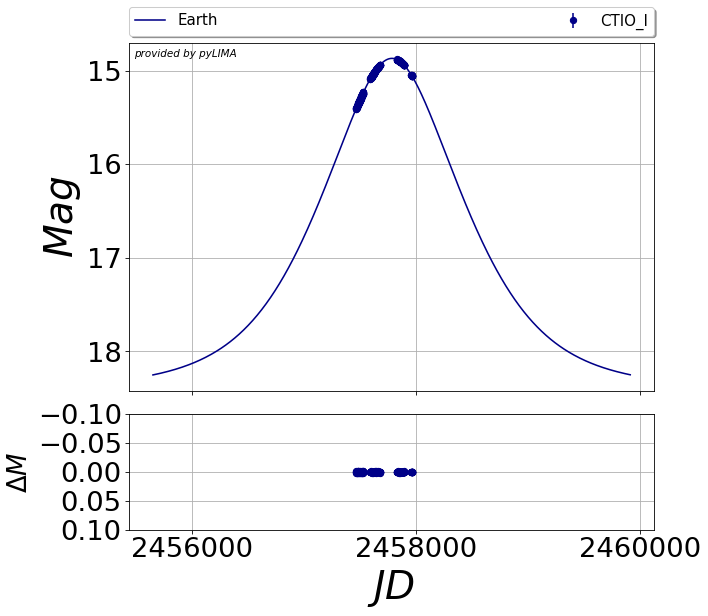

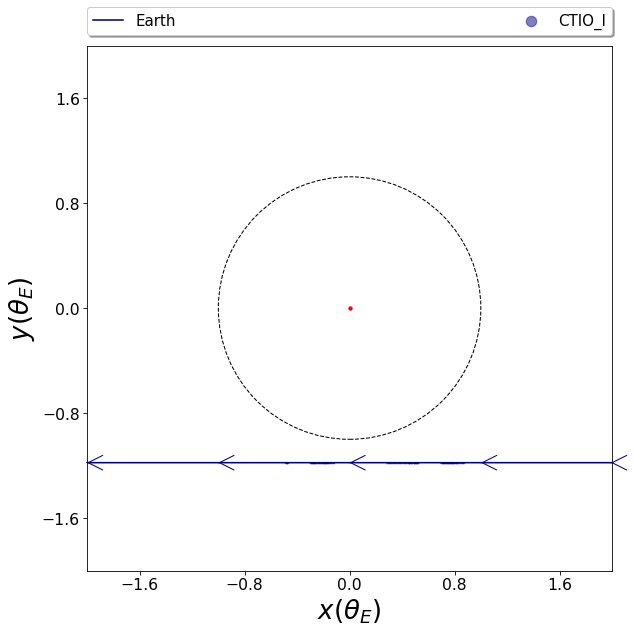

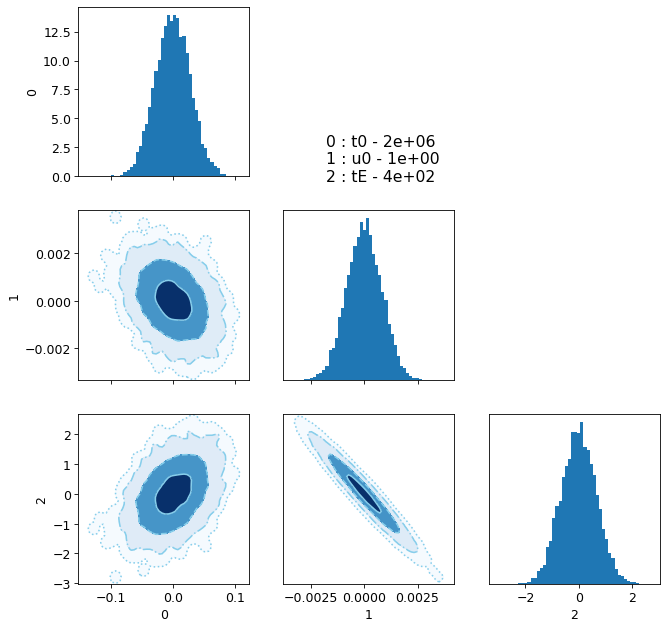

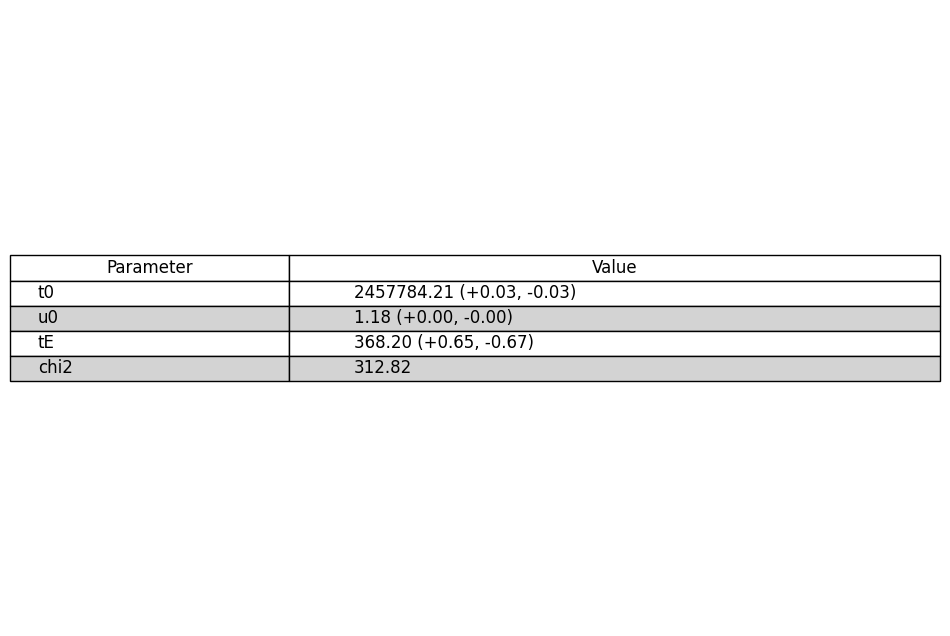

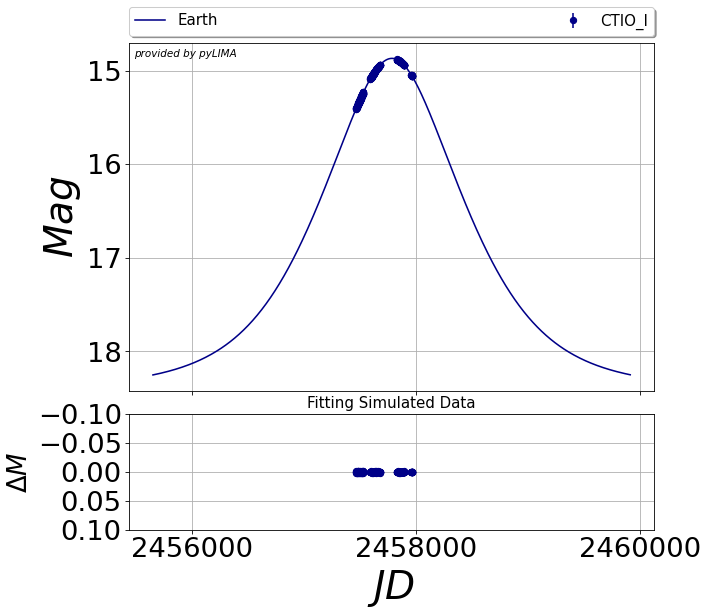

In [58]:
#@title Fit Simulated Data
# Now fit the simulated data to recover parameters
sim_fit = LM_fit.LMfit(sim_pspl)
sim_fit.fit()
sim_fit.fit_outputs()

print("Fit Results vs Truth:")
print("Parameter | Truth    | Fit      | Difference")
print("---------|----------|----------|-----------")

param_names = list(sim_pspl.model_dictionnary.keys())
for i, name in enumerate(param_names[:3]):  # t0, u0, tE
    truth = sim_parameters[i]
    fit = sim_fit.fit_results['best_model'][i]
    diff = fit - truth
    print(f"{name:8} | {truth:8.4f} | {fit:8.4f} | {diff:+8.4f}")

print(f"\nChi-squared: {sim_fit.fit_results['chi2']:.2f}")

# Plot fit results
pyLIMA_plots.plot_lightcurves(sim_pspl, sim_fit.fit_results['best_model'])
plt.title("Fitting Simulated Data")
plt.show()

### <font face="Helvetica" size="5"> 2.4 Advanced Features </font>

pyLIMA offers several advanced features including custom parameter definitions and multiple fitting algorithms.

#### <font face="Helvetica" size="4"> 2.4.1 Custom Parameter Definitions </font>

pyLIMA allows you to define custom parameter transformations, which can be useful for better sampling or physical interpretation.

In [64]:
#@title Custom Parameter Definitions
# Define custom parameters: log_tE instead of tE
class MyFancyParameters(object):
    def __init__(self, fancy_parameters={'tE': 'log_tE'},
                 fancy_boundaries={'log_tE': (0, 3)}):
        self.fancy_parameters = fancy_parameters
        self.fancy_boundaries = fancy_boundaries

    def tE(self, fancy_params):
        return 10**fancy_params['log_tE']

    def log_tE(self, standard_params):
        return np.log10(standard_params['tE'])

# Create model with custom parameters
my_pars = MyFancyParameters()
fspl_custom = FSPL_model.FSPLmodel(your_event, fancy_parameters=my_pars)

print("Custom parameter model created")
print(f"Fancy parameters: {my_pars.fancy_parameters}")
print(f"Custom boundaries: {my_pars.fancy_boundaries}")

Custom parameter model created
Fancy parameters: {'tE': 'log_tE'}
Custom boundaries: {'log_tE': (0, 3)}


In [62]:
#@title Fit with Custom Parameters
# Use Trust Region Reflective algorithm
trf_fit = TRF_fit.TRFfit(fspl_custom)

# Set initial guess (convert tE to log_tE)
guess_parameters = [t0, u0, np.log10(tE), 0.001]  # t0, u0, log_tE, rho
trf_fit.model_parameters_guess = guess_parameters

print("Running TRF fit with custom parameters...")
trf_fit.fit()

print("\nFit Results (custom parameters):")
print(trf_fit.fit_results['best_model'])
print(f"\nChi-squared: {trf_fit.fit_results['chi2']:.2f}")

# Convert back to standard parameters for comparison
custom_params = trf_fit.fit_results['best_model']
standard_tE = 10**custom_params[2]  # Convert log_tE back to tE
print(f"\nConverted t_E: {standard_tE:.2f} days")
print(f"Truth t_E: {tE:.2f} days")
print(f"Difference: {standard_tE - tE:.2f} days")

Running TRF fit with custom parameters...
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459123.5, 0.1, 1.3979400086720377, 0.001, 5762.132314066182, 5757.853640543245]
Trust Region Reflective fit SUCCESS
best model:
OrderedDict([('t0', 2459123.4852720723),
             ('u0', 0.09811846926946088),
             ('log_tE', 1.403420683786682),
             ('rho', 0.006255844893156886),
             ('fsource_OGLE', 5657.6760660566315),
             ('ftotal_OGLE', 5746.581236013795),
             ('tE', 25.317492137966077),
             ('chi2', 79.72259733896976)])

Fit Results (custom parameters):
[2.45912349e+06 9.81184693e-02 1.40342068e+00 6.25584489e-03
 5.65767607e+03 5.74658124e+03]

Chi-squared: 79.72

Converted t_E: 25.32 days
Truth t_E: 25.00 days
Difference: 0.32 days


#### <font face="Helvetica" size="4"> 2.4.2 Multiple Telescopes and Filters </font>

pyLIMA excels at handling data from multiple telescopes and filters, which is common in modern microlensing surveys.

In [66]:
#@title Multiple Telescope Example
# Create a new event with multiple telescopes
multi_event = event.Event()
multi_event.name = 'Multi-Telescope Event'

# Generate data for multiple telescopes with different properties
telescopes_data = []
telescope_names = ['OGLE', 'MOA', 'LCO']
filters = ['I', 'R', 'V']
offsets = [0.0, 0.1, -0.05]  # Different zero points
noise_levels = [0.01, 0.015, 0.02]  # Different noise levels

for i, (name, filt, offset, noise) in enumerate(zip(telescope_names, filters, offsets, noise_levels)):
    # Generate light curve with different properties
    mag_tel = mag + offset + np.random.normal(0, noise, len(mag))
    mag_err_tel = noise * np.ones_like(mag)

    lightcurve_data = np.column_stack([times, mag_tel, mag_err_tel])

    telescope = telescopes.Telescope(
        name=name,
        camera_filter=filt,
        lightcurve=lightcurve_data.astype(float),
        lightcurve_names=['time', 'mag', 'err_mag'],
        lightcurve_units=['JD', 'mag', 'mag']
    )

    multi_event.telescopes.append(telescope)
    telescopes_data.append(lightcurve_data)

# Set survey telescope
multi_event.find_survey('OGLE')
multi_event.check_event()

print(f"Created event with {len(multi_event.telescopes)} telescopes:")
for tel in multi_event.telescopes:
    print(f"  {tel.name} ({tel.filter}-band): {len(tel.lightcurve)} points")

check_event  : Everything looks fine...
Created event with 3 telescopes:
  OGLE (I-band): 100 points
  MOA (R-band): 100 points
  LCO (V-band): 100 points


DE converge to objective function : f(x) =  348.20488162011156
DE converge to parameters : =  ['2459123.487569642' '-0.0995782146202433' '25.107612092235627']
fit  : Differential Evolution fit SUCCESS
best model:
OrderedDict([('t0', 2459123.487569642),
             ('u0', -0.0995782146202433),
             ('tE', 25.107612092235627),
             ('fsource_OGLE', 5753.612149870587),
             ('ftotal_OGLE', 5742.484440348775),
             ('fsource_MOA', 5242.486028700498),
             ('ftotal_MOA', 5235.246918969096),
             ('fsource_LCO', 6019.748646732077),
             ('ftotal_LCO', 6000.752507141806),
             ('chi2', 348.20488162011156)])
Multi-telescope fit results:
[ 2.45912349e+06 -9.95782146e-02  2.51076121e+01  5.75361215e+03
  5.74248444e+03  5.24248603e+03  5.23524692e+03  6.01974865e+03
  6.00075251e+03  3.48204882e+02  0.00000000e+00]

Chi-squared: 348.20


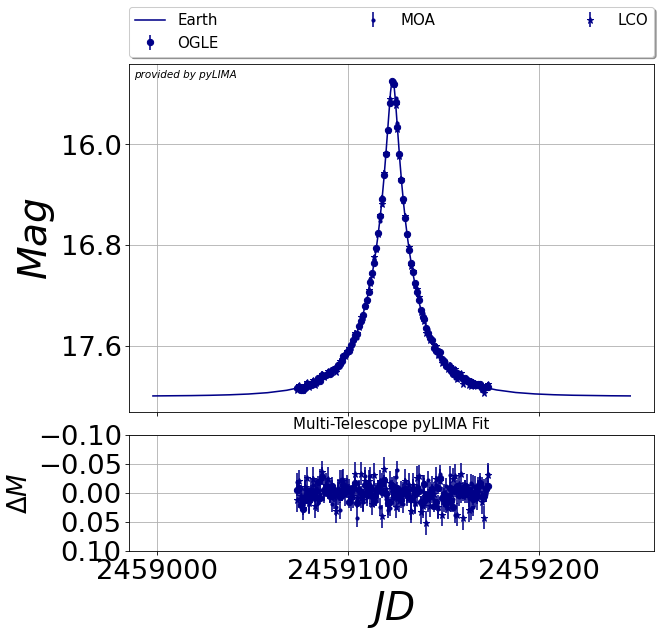


Flux parameters for each telescope:
OGLE (I): 5753.61
MOA (R): 5742.48
LCO (V): 5242.49


In [69]:
#@title Fit Multi-Telescope Data
# Create PSPL model for multi-telescope data
multi_pspl = PSPL_model.PSPLmodel(multi_event)

# Fit with differential evolution
multi_fit = DE_fit.DEfit(multi_pspl, loss_function='chi2')
multi_fit.fit()

print("Multi-telescope fit results:")
print(multi_fit.fit_results['best_model'])
print(f"\nChi-squared: {multi_fit.fit_results['chi2']:.2f}")

# Plot results
pyLIMA_plots.plot_lightcurves(multi_pspl, multi_fit.fit_results['best_model'])
plt.title("Multi-Telescope pyLIMA Fit")
plt.show()

# Show flux parameters for each telescope
print("\nFlux parameters for each telescope:")
param_names = list(multi_pspl.model_dictionnary.keys())
for i, tel in enumerate(multi_event.telescopes):
    flux_param = multi_fit.fit_results['best_model'][3 + i]  # Flux parameters start at index 3
    print(f"{tel.name} ({tel.filter}): {flux_param:.2f}")

### <font face="Helvetica" size="5"> 2.5 Performance and Best Practices </font>

pyLIMA offers several fitting algorithms, each with different strengths:

**Fitting Algorithms:**
- **LM (Levenberg-Marquardt)**: Fast, good for initial fits
- **DE (Differential Evolution)**: Robust, handles complex parameter spaces
- **MCMC**: Best for uncertainty estimation and posterior sampling
- **TRF (Trust Region Reflective)**: Good for constrained optimization

**Best Practices:**
- Start with LM for quick initial fits
- Use DE for complex models or when LM fails
- Use MCMC for final parameter estimation and uncertainties
- Set appropriate parameter bounds for better convergence
- Use custom parameters for better sampling (e.g., log_tE instead of tE)
- Always check event setup with `check_event()`

**Performance Tips:**
- Use `rescale_photometry=True` in MCMC for better numerical stability
- Set appropriate burn-in periods for MCMC chains
- Use simulation capabilities to test your analysis pipeline
- Consider using custom parameters for better sampling efficiency

## 3. RTModel

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

RTModel (Real-Time Model) is a sophisticated, hands-off microlensing modeling package developed by Valerio Bozza. Unlike other tools that require manual model selection, RTModel automatically determines the best model type for your event through a comprehensive grid search and template library approach. It's designed to be a "set it up and press go" solution that provides automated model interpretation.

**Key Features:**
- **Automated Model Selection**: Determines whether an event is single-lens, binary-lens, binary-source, etc.
- **Template Library**: Uses pre-computed binary lens templates for efficient fitting
- **Parallel Processing**: Exploits all available CPU cores for fast analysis
- **Comprehensive Models**: Supports 7+ model categories including parallax and orbital motion
- **Built-in Assessment**: Provides automatic interpretation of results
- **Visualization Tools**: Includes plotting and animation capabilities

### <font face="Helvetica" size="5"> 3.1 Installation and Setup </font>

RTModel requires a C++17 compiler and uses VBMicrolensing for calculations. It can be installed via pip or from source.

In [ ]:
#@title Install RTModel
# RTModel can be installed via pip
!pip install RTModel

# Import RTModel
import RTModel
import RTModel.plotmodel as plm

print("RTModel installed and imported successfully!")
print(f"RTModel version: {RTModel.__version__}" if hasattr(RTModel, '__version__') else "RTModel imported")

RTModel installed and imported successfully!
RTModel version: 3.0


### <font face="Helvetica" size="5"> 3.2 Data Preparation </font>

RTModel requires a specific directory structure and data format. Each event needs its own directory with a `/Data` subdirectory containing the photometry files.

In [24]:
#@title Create RTModel Directory Structure
import os
import shutil

# Create event directory structure for RTModel
event_dir = 'rtmodel_event001'
data_dir = os.path.join(event_dir, 'Data')

# Create directories
os.makedirs(data_dir, exist_ok=True)

print(f"Created RTModel directory structure:")
print(f"  {event_dir}/")
print(f"  {event_dir}/Data/")

# RTModel requires this specific structure:
# event_dir/
# ├── Data/
# │   ├── telescope1.dat
# │   ├── telescope2.dat
# │   └── event001.coordinates
# └── (other files created by RTModel)

Created RTModel directory structure:
  rtmodel_event001/
  rtmodel_event001/Data/


In [25]:
#@title Create RTModel Data Files
# RTModel expects data in a specific format:
# # Mag err HJD-2450000
# 19.0232 0.012 8370.1223
# 19.0150 0.011 8370.2421
# ...

# Let's create a sample data file using our synthetic microlensing data
def create_rtmodel_data_file(filename, times, mags, mag_errs):
    """Create RTModel-compatible data file"""
    with open(filename, 'w') as f:
        f.write("# Mag err HJD-2450000\n")
        for t, m, e in zip(times, mags, mag_errs):
            # Convert to HJD-2450000 format
            hjd_offset = t - 2450000
            f.write(f"{m:.4f} {e:.3f} {hjd_offset:.4f}\n")

# Create sample data file
data_file = os.path.join(data_dir, 'ogle.dat')
create_rtmodel_data_file(data_file, times, mag, mag_err)

print(f"Created data file: {data_file}")
print(f"Data points: {len(times)}")

# Show first few lines
with open(data_file, 'r') as f:
    lines = f.readlines()
    print("\nFirst 5 lines of data file:")
    for i, line in enumerate(lines[:5]):
        print(f"  {i+1}: {line.strip()}")

Created data file: rtmodel_event001/Data/ogle.dat
Data points: 100

First 5 lines of data file:
  1: # Mag err HJD-2450000
  2: 17.9413 0.010 9073.5000
  3: 17.9311 0.010 9074.5101
  4: 17.9350 0.010 9075.5202
  5: 17.9394 0.010 9076.5303


In [26]:
#@title Create Coordinates File
# RTModel requires event coordinates in a specific format
# Format: HH:MM:SS.S +DD:PP:SS.S

# Convert our coordinates to the required format
def decimal_to_hms(ra_deg, dec_deg):
    """Convert decimal degrees to HH:MM:SS.S +DD:PP:SS.S format"""
    # Convert RA (hours)
    ra_hours = ra_deg / 15.0  # Convert degrees to hours
    ra_h = int(ra_hours)
    ra_m = int((ra_hours - ra_h) * 60)
    ra_s = ((ra_hours - ra_h - ra_m/60) * 3600)

    # Convert Dec (degrees)
    dec_sign = '+' if dec_deg >= 0 else '-'
    dec_deg_abs = abs(dec_deg)
    dec_d = int(dec_deg_abs)
    dec_m = int((dec_deg_abs - dec_d) * 60)
    dec_s = ((dec_deg_abs - dec_d - dec_m/60) * 3600)

    ra_str = f"{ra_h:02d}:{ra_m:02d}:{ra_s:04.1f}"
    dec_str = f"{dec_sign}{dec_d:02d}:{dec_m:02d}:{dec_s:04.1f}"

    return f"{ra_str} {dec_str}"

# Create coordinates file
coords_file = os.path.join(data_dir, 'event001.coordinates')
coords_str = decimal_to_hms(ra, dec)

with open(coords_file, 'w') as f:
    f.write(coords_str)

print(f"Created coordinates file: {coords_file}")
print(f"Coordinates: {coords_str}")
print(f"Original coordinates: RA={ra:.6f}°, Dec={dec:.6f}°")

Created coordinates file: rtmodel_event001/Data/event001.coordinates
Coordinates: 17:57:16.6 -29:05:20.0
Original coordinates: RA=269.319000°, Dec=-29.088900°


### <font face="Helvetica" size="5"> 3.3 Basic Usage </font>

RTModel is designed to be simple to use - just set up your data and run the analysis. The tool automatically determines the best model type.

In [27]:
#@title Initialize RTModel
# Create RTModel instance
rtm = RTModel.RTModel(event_dir)

# Check number of processors (RTModel uses all available by default)
print(f"RTModel initialized for event: {event_dir}")
print(f"Available processors: {rtm.nprocessors}")

# You can limit the number of processors if needed
# rtm.set_processors(4)  # Use only 4 processors

*********************
****   RTModel   ****
*********************
Event name: /home/meet/data-challenge-notebooks/Extras/rtmodel_event001
Number of processors: 16
RTModel initialized for event: rtmodel_event001
Available processors: 16


RTModel will automatically:
  1. Pre-process the data
  2. Generate initial conditions
  3. Fit all model categories
  4. Select best models
  5. Provide final assessment

In [ ]:
#@title Run RTModel Analysis
# This is the main command - RTModel does everything automatically!
print("Starting RTModel analysis...")
print("This may take several minutes depending on your machine.")
print("RTModel will fit 7 different model categories:")
print("  PS: Single-lens-single-source")
print("  PX: Single-lens-single-source with parallax")
print("  BS: Single-lens-binary-source")
print("  BO: Single-lens-binary-source with xallarap")
print("  LS: Binary-lens-single-source")
print("  LX: Binary-lens-single-source with parallax")
print("  LO: Binary-lens-single-source with orbital motion")

# Uncomment the line below to actually run RTModel
rtm.run()

print("\nNote: RTModel run commented out to avoid long execution.")
print("Uncomment rtm.run() to perform the actual analysis.")

Starting RTModel analysis...
This may take several minutes depending on your machine.
RTModel will fit 7 different model categories:
  PS: Single-lens-single-source
  PX: Single-lens-single-source with parallax
  BS: Single-lens-binary-source
  BO: Single-lens-binary-source with xallarap
  LS: Binary-lens-single-source
  LX: Binary-lens-single-source with parallax
  LO: Binary-lens-single-source with orbital motion

Note: RTModel run commented out to avoid long execution.
Uncomment rtm.run() to perform the actual analysis.


### <font face="Helvetica" size="5"> 3.4 Understanding RTModel Output </font>

After running RTModel, you'll get several output files and directories. Let's explore what each contains.

**RTModel creates the following output structure:**

```
<event_dir>/
├── Data/                    # Original input data
├── ini/                     # Configuration files
├── InitCond/                # Initial conditions for fitting
├── Models/                  # Selected models for each category
├── FinalModels/             # Best models from final assessment
├── LCToFit.txt              # Pre-processed data
├── FilterToData.txt         # Dataset mapping
├── spline.txt               # Spline approximation points
└── nature.txt               # Final assessment and best models
```

**Key output files:**
  `nature.txt`: Contains the final assessment and list of best models
  `FinalModels/`: Contains the best model files with parameters and uncertainties
  `Models/`: Contains selected models for each category

#### Understanding the nature.txt File

The `nature.txt` file contains RTModel's assessment of the event

**The nature.txt file contains:**

1. Best chi-square for each model category:
  - `PS`: Single-lens-single-source
  - `PX`: Single-lens-single-source with parallax
  - `BS`: Single-lens-binary-source
  - `BO`: Single-lens-binary-source with xallarap
  - `LS`: Binary-lens-single-source
  - `LX`: Binary-lens-single-source with parallax
  - `LO`: Binary-lens-single-source with orbital motion

2. Final assessment of the event nature

3. List of proposed best models

4. Model comparison and interpretation

**Example `nature.txt` content:**

```nature.txt
*********************
****   RTModel   ****
*********************

Best chi-square for each category:
PS: 1234.56 (Single-lens-single-source)
PX: 1230.45 (Single-lens-single-source with parallax)
BS: 1235.67 (Single-lens-binary-source)
BO: 1232.34 (Single-lens-binary-source with xallarap)
LS: 1238.90 (Binary-lens-single-source)
LX: 1235.12 (Binary-lens-single-source with parallax)
LO: 1236.78 (Binary-lens-single-source with orbital motion)

Final Assessment:
This appears to be a single-lens event with parallax effects.
The best model is PX with chi-square = 1230.45
```

### <font face="Helvetica" size="5"> 3.5 Model Categories </font>

RTModel fits 7 different model categories by default. Each has a specific label and parameter set.

#### RTModel Model Categories

| Label | Model | Parameters | Description |
|-------|-------|------------|-------------|
| `PS` | Single-lens-single-source | 4 | Basic microlensing (`t0`, `u0`, `tE`, `rho`) |
| `PX` | Single-lens-single-source with parallax | 6 | Basic + parallax effects |
| `BS` | Single-lens-binary-source | 7 | Two source stars, one lens |
| `BO` | Single-lens-binary-source with xallarap | 10 | Binary source + orbital motion |
| `LS` | Binary-lens-single-source | 7 | Two lens components (planetary) |
| `LX` | Binary-lens-single-source with parallax | 9 | Binary lens + parallax |
| `LO` | Binary-lens-single-source with orbital motion | 12 | Binary lens + orbital motion |

#### Additional categories available:
- `LK`: Binary-lens-single-source with eccentric orbital motion (14 parameters)

**Parameter details for each model category:**

| Parameter | PS | PX | BS | BO | LS | LX | LO | Notes |
|-----------|----|----|----|----|----|----|----|-------|
| `u0` | ✅* | ✅ | ✅ | ✅ | ✅ | ✅ | ✅ | Impact parameter |
| `tE` | ✅* | ✅* | ✅* | ✅* | ✅* | ✅* | ✅* | Einstein time in days |
| `t0` | ✅ | ✅ | ✅ | ✅ | ✅ | ✅ | ✅ | Closest approach time in HJD |
| `rho` | ✅* | ✅* | ✅* | ✅* | ✅* | ✅* | ✅* | Source radius |
| `piN` | ❌ | ✅ | ❌ | ❌ | ❌ | ✅ | ❌ | Parallax component along North |
| `piE` | ❌ | ✅ | ❌ | ❌ | ❌ | ✅ | ❌ | Parallax component along East |
| `s` | ❌ | ❌ | ❌ | ❌ | ✅* | ✅* | ✅* | Separation between lenses |
| `q` | ❌ | ❌ | ❌ | ❌ | ✅* | ✅* | ✅* | Mass ratio |
| `alpha` | ❌ | ❌ | ❌ | ❌ | ✅ | ✅ | ✅ | Angle of source trajectory |
| `q_S` | ❌ | ❌ | ✅ | ✅ | ❌ | ❌ | ❌ | Source flux ratio |
| `rho_S` | ❌ | ❌ | ✅* | ✅* | ❌ | ❌ | ❌ | Source separation |
| `theta_S` | ❌ | ❌ | ✅ | ✅ | ❌ | ❌ | ❌ | Source angle |

> key: `*` - ln scale

### <font face="Helvetica" size="5"> 3.6 Visualization and Results </font>

RTModel includes built-in visualization tools through the `plotmodel` subpackage.

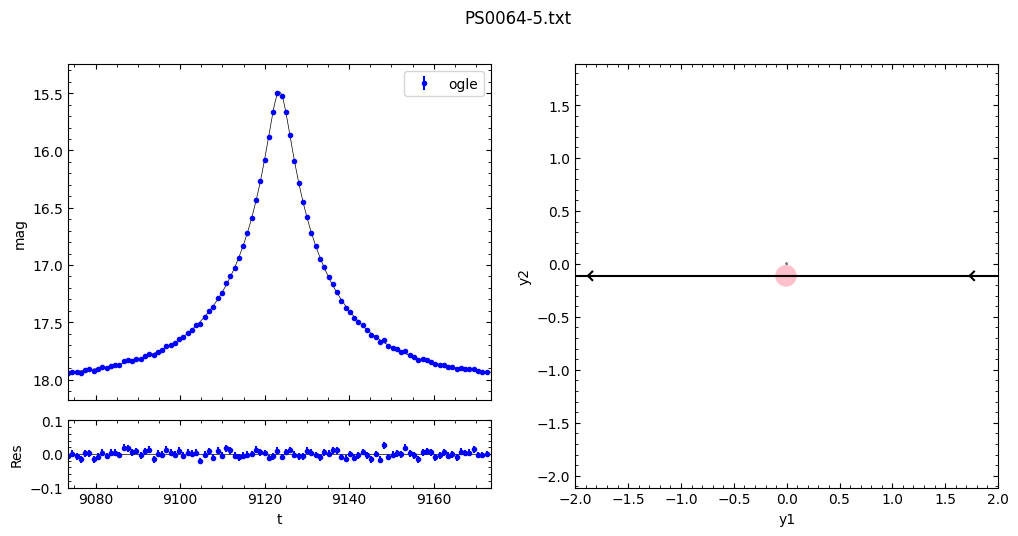

╒════════╤═══════════════════╕
│ chi2   │ 79.339803134301   │
╞════════╪═══════════════════╡
│ u0     │ 0.1124 +- 0.0091  │
├────────┼───────────────────┤
│ tE     │ 25.00 +- 0.56     │
├────────┼───────────────────┤
│ t0     │ 9123.485 +- 0.013 │
├────────┼───────────────────┤
│ rho    │ 0.095 +- 0.023    │
╘════════╧═══════════════════╛

╒═════════════╤═══════════════════╤═════════════════╕
│ telescope   │ baseline          │ blending        │
╞═════════════╪═══════════════════╪═════════════════╡
│ ogle        │ 17.9999 +- 0.0038 │ -0.002 +- 0.030 │
╘═════════════╧═══════════════════╧═════════════════╛
RTModel plotting is done through the plotmodel class
Example: myplot = plm.plotmodel(eventname, modelfile=modelfile)
See the RTModel astrometric visualization section for working examples


In [41]:
#@title RTModel Plotting
# RTModel includes plotting capabilities through the plotmodel class

import RTModel.plotmodel as plm

# The main way to use RTModel plotting is to create a plotmodel object
# after you've run RTModel analysis

# Example (uncomment after running RTModel):
myplot = plm.plotmodel(eventname, modelfile=modelfile)
# This creates a plot showing:
#   - Light curve data with model fit
#   - Residuals
#   - Astrometry (if available)
#   - Best-fit parameters table

# For more plotting options, see the RTModel astrometric visualization section below
# where we demonstrate plotmodel, showastrometry, showastrometryRA/Dec functions

print("RTModel plotting is done through the plotmodel class")
print("Example: myplot = plm.plotmodel(eventname, modelfile=modelfile)")
print("See the RTModel astrometric visualization section for working examples")

#### How to analyze RTModel results:

1. Check nature.txt for the final assessment

   - Best chi-square for each model category
   - RTModel's interpretation of the event
   - List of proposed best models

2. Examine FinalModels/ directory

   - Each file contains parameters and uncertainties
   - First line: parameters + fluxes + chi-square
   - Second line: parameter uncertainties
   - Remaining lines: covariance matrix

3. Compare models using chi-square

   - Lower chi-square = better fit
   - Consider degrees of freedom (more parameters = higher expected chi-square)
   - Use F-test or AIC/BIC for model comparison

4. Validate results

   - Check parameter uncertainties
   - Examine residuals
   - Look for systematic effects
   - Consider physical plausibility

### <font face="Helvetica" size="5"> 3.7 Advanced Features </font>

RTModel offers several advanced features for customization and control.

In [29]:
#@title: 1. Model Category Selection:

# Fit only specific model categories using config_InitCond
rtm.config_InitCond(modelcategories=['PS', 'LS'])  # Only single-lens and binary-lens
print("Model categories configured: PS (single-lens) and LS (binary-lens)")

Model categories configured: PS (single-lens) and LS (binary-lens)


In [30]:
#@title: 2. Fitting Options:

# Configure Levenberg-Marquardt fitting
rtm.config_LevMar(nfits=10, timelimit=1200.0, maxsteps=100)


In [31]:
#@title: 3. Parameter Constraints:

# Set gaussian constraints on parameters
# Constraints format: [parameter_name, mean, sigma, type]
rtm.set_constraints([('tE', 25.0, 2.0, 'gaussian')])  # tE = 25 ± 2 days

In [32]:
#@title: 4. Parallel Processing:

# Control number of processors
rtm.set_processors(8)  # Use 8 processors

In [33]:
#@title: 5. Step-by-step Execution:

# Run individual steps manually
rtm.Reader()           # Data pre-processing
rtm.InitCond()        # Generate initial conditions
rtm.launch_fits('PS') # Fit specific category
rtm.ModelSelector('PS')  # Select best models for the category
rtm.Finalizer()       # Final assessment

- Launching: Reader
  Pre-processing data...
  OK
- Launching: InitCond
  Setting initial conditions...
Peaks:  9125.0150  9122.9950  
  OK
- Single-lens-Single-source fits
Fits completed:   0%|          | 0/120 [00:00<?, ?it/s]

Fits completed: 100%|██████████| 120/120 [00:01<00:00, 63.08it/s]
  OK
- Selecting models for Single-lens-Single-source fits
  OK
- Launching: Finalizer
  Making final assessment for this event
  PS: 79.339803
  
  BestPlanetary: N/A
  BestBinary: N/A
  
  Successful: Single-Lens-Single-Source
  ----
  Number of alternative models: 1
  
  chisquare   model
  79.339803 PS0064-5.txt
  OK


### <font face="Helvetica" size="5"> 3.8 RTModel Best Practices </font>

**1. Data Quality:**
- Ensure data is properly formatted
- Check for systematic errors
- Verify coordinate accuracy

**2. Computational Resources:**
- Use all available processors for speed
- Allow sufficient time (1-3 hours typical)
- Ensure adequate disk space

**3. Model Interpretation:**
- Don't rely solely on chi-square
- Consider physical plausibility
- Check parameter uncertainties
- Validate against known physics

**4. Troubleshooting:**
- Check ini/ directory for configuration
- Examine error messages in output
- Verify data format compliance
- Use step-by-step execution for debugging

**5. Results Validation:**
- Compare with other fitting codes
- Check for systematic residuals
- Verify parameter correlations
- Consider alternative models

### <font face="Helvetica" size="5"> 3.9 RTModel vs Other Tools </font>

RTModel offers a unique approach compared to other microlensing fitting tools.

#### <font face="Helvetica" size="4"> Comparison with Other Tools </font>

**RTModel vs Other Microlensing Tools:**

| Feature | RTModel | MulensModel | pyLIMA |
|---------|---------|-------------|--------|
| Model Selection | Automatic | Manual | Manual |
| Ease of Use | Moderate set up <br> Very easy to run | Moderate | Moderate |
| Speed | Fast (parallel) | Variable | Variable |
| Automation | High | Low | Low |
| Customization | Moderate | High | High |
| Visualization | Built-in | Basic | Good |
| Parallel Processing | Yes | Manual | Manual |

**RTModel Advantages:**
- Hands-off operation - just set up data and run
- Automatic model selection and interpretation
- Template library for efficient binary lens fitting
- Built-in assessment and visualization
- Parallel processing for speed

**RTModel Limitations:**
- Less customization than manual tools
- Requires specific data format
- Limited to supported model categories
- May miss subtle effects in complex events

### <font face="Helvetica" size="5"> 3.10 Astrophotometric Fitting (RTModel v3.0) </font>

**NEW IN RTModel v3.0!** RTModel now supports combined photometric and astrometric fitting, making it the first tool to offer comprehensive astrophotometric microlensing analysis. This capability is crucial for space-based observations like Roman, where milliarcsecond astrometric precision enables measurement of the centroid trajectory during microlensing events.

**Key Astrometric Features:**
- **Combined Fitting**: Simultaneous photometric and astrometric parameter estimation
- **Centroid Trajectory**: Models the astrometric shift of images during events
- **Proper Motion**: Measures source and lens proper motions
- **Einstein Angle**: Direct measurement of θ_E from astrometry
- **Source Parallax**: Geometric parallax of the source star
- **Visualization**: Built-in astrometric plotting and trajectory visualization

#### <font face="Helvetica" size="4"> 3.10.1 Astrophotometric Data Format </font>

Astrophotometric datasets include both photometric and astrometric information.

**RTModel File Structure:**
- RTModel uses **SEPARATE FILES** for photometry and astrometry
- Photometry file: `<telescope>.dat` (e.g., `ogle.dat`) - 3 columns
- Astrometry file: `<telescope>_astro.dat` (e.g., `ogle_astro.dat`) - 7 columns

Astrophotometric data files have 7 columns: `Mag`, `err`, `HJD-2450000`, `Dec`, `errDec`, `RA`, `errRA`

**Example astrophotometric data (`ogle_astro.dat`):**

```
# Mag err HJD-2450000 Dec errDec RA errRA
19.0232 0.012 8370.1223 1.2534 1.0 0.0165 1.0
19.0150 0.011 8370.2421 1.7510 1.1 -0.5422 1.1
19.0034 0.011 8370.3697 1.1190 1.1 -0.1981 1.1
18.9712 0.010 8370.4911 1.4281 1.0 0.2119 1.0
18.9592 0.011 8370.6114 1.3005 0.9 0.3982 1.0
18.9109 0.009 8370.8234 1.6233 1.0 0.5121 1.0
18.8798 0.009 8371.0092 2.0223 1.2 0.9411 1.1
```

**Column descriptions:**

  - `Mag`: Magnitude
  - `err`: Photometric error
  - `HJD-2450000`: Heliocentric Julian Date - 2450000
  - `Dec`: Declination offset in milliarcseconds
  - `errDec`: Declination error in milliarcseconds
  - `RA`: Right Ascension offset in milliarcseconds
  - `errRA`: Right Ascension error in milliarcseconds

> Note: Dec and RA are angular displacements from a fixed reference point
in the North and East directions respectively.

In [66]:
#@title Create Astrophotometric Data (RTModel separate file format)
import numpy as np
import shutil

# RTModel requires a SEPARATE astrometry file: <telescope>_astro.dat
# The main ogle.dat file remains photometry-only (3 columns)
# The ogle_astro.dat file contains ONLY the astrometric points (7 columns)

ogle_astro_path = os.path.join(eventname, 'Data', 'ogle_astro.dat')

# Read the model parameters we need for astrometric calculation
t0_astro = t_0  # Peak time from our model
tE_astro = params['t_E']  # Einstein time from our model  
u0_astro = params['u_0']  # Impact parameter from our model

print(f"Using model parameters: t_0={t0_astro:.2f}, t_E={tE_astro:.2f}, u_0={u0_astro:.3f}")

# Create separate astrometric data file
# RTModel expects: # Mag err HJD-2450000 Dec errDec RA errRA
# Sample every 5th photometric point to have astrometry
astro_times = []
astro_dec = []
astro_ra = []
astro_mag = []
astro_err = []

for i, (t, m, e) in enumerate(zip(times, mag, mag_err)):
    if i % 5 == 0:  # Astrometry every 5th observation
        # Calculate astrometric displacement using microlensing model
        # u(t) = sqrt(u0^2 + ((t-t0)/tE)^2)
        u = np.sqrt(u0_astro**2 + ((t - t0_astro) / tE_astro)**2)
        
        # Astrometric shift (centroid displacement) in milliarcseconds
        # For microlensing, the centroid shift is proportional to u/(u^2 + 2)
        shift_dec = u0_astro**2 / (u**2 + 2) * 1.5  # Scale to mas
        shift_ra = u0_astro * (t - t0_astro) / tE_astro / (u**2 + 2) * 1.5  # Scale to mas
        
        # Add realistic noise (typical for space-based astrometry)
        noise_dec = 0.8  # mas
        noise_ra = 0.9   # mas
        dec_obs = shift_dec + np.random.normal(0, noise_dec * 0.3)
        ra_obs = shift_ra + np.random.normal(0, noise_ra * 0.3)
        
        astro_times.append(t)
        astro_mag.append(m)
        astro_err.append(e)
        astro_dec.append(dec_obs)
        astro_ra.append(ra_obs)

# Write separate astrometric file
with open(ogle_astro_path, 'w') as f:
    f.write("# Mag err HJD-2450000 Dec errDec RA errRA\n")
    for t, m, e, dec, ra in zip(astro_times, astro_mag, astro_err, astro_dec, astro_ra):
        hjd_offset = t - 2450000
        f.write(f"{m:.4f} {e:.3f} {hjd_offset:.4f} {dec:.4f} 0.8 {ra:.4f} 0.9\n")

print(f"\n✓ Created {ogle_astro_path} with astrometric data")
print(f"  Total astrometric points: {len(astro_times)}")
print(f"  Astrometric precision: 0.8 mas (Dec), 0.9 mas (RA)")

# Show first few lines
with open(ogle_astro_path, 'r') as f:
    lines = f.readlines()
    print("\nFirst 5 astrometric data lines:")
    for i, line in enumerate(lines[:6]):
        print(f"  {line.strip()}")
        
print("\n⚠ IMPORTANT: You must re-run RTModel (cell 123) for it to read this astrometric data!")

Using model parameters: t_0=2459816.21, t_E=2.04, u_0=-0.078

✓ Created /home/meet/data-challenge-notebooks/Extras/rtmodel_event001/Data/ogle_astro.dat with astrometric data
  Total astrometric points: 20
  Astrometric precision: 0.8 mas (Dec), 0.9 mas (RA)

First 5 astrometric data lines:
  # Mag err HJD-2450000 Dec errDec RA errRA
  17.9413 0.010 9073.5000 0.0691 0.8 0.0142 0.9
  17.9123 0.010 9078.5505 -0.0941 0.8 0.2705 0.9
  17.8792 0.010 9083.6010 0.2217 0.8 -0.1510 0.9
  17.8339 0.010 9088.6515 -0.2948 0.8 0.0488 0.9
  17.7892 0.010 9093.7020 0.2846 0.8 -0.3404 0.9

⚠ IMPORTANT: You must re-run RTModel (cell 123) for it to read this astrometric data!


#### <font face="Helvetica" size="4"> 3.10.2 Astrophotometric Parameters </font>

When RTModel detects astrophotometric data, it automatically adds 4 additional parameters to the fit:

| Parameter | Meaning | Physical Significance |
|-----------|---------|---------------------|
| `muS_Dec` | Source proper motion component in North direction (mas/yr) | Source motion perpendicular to line of sight |
| `muS_RA` | Source proper motion component in East direction (mas/yr) | Source motion perpendicular to line of sight |
| `piS` | Geometric parallax of the source (mas) | Distance to source star |
| `thetaE` | Einstein angle (mas) | Lens mass and distance (θ_E = √(4GM/c²D_L)) |

**Model Categories for Astrophotometric Fits:**
* `PX`: Single-lens-single-source with parallax (10 parameters)
* `BO`: Single-lens-binary-source with xallarap (14 parameters)
* `LX`: Binary-lens-single-source with parallax (13 parameters)
* `LO`: Binary-lens-single-source with orbital motion (16 parameters)
* `LK`: Binary-lens-single-source with eccentric orbital motion (18 parameters)

> Note: No static models are fitted in astrophotometric mode because parallax is always included to model the centroid trajectory.

#### <font face="Helvetica" size="4"> 3.10.3 Astrophotometric Fitting </font>

RTModel automatically detects astrophotometric datasets and switches to combined fitting mode.

**RTModel Astrophotometric Fitting:**

1. Automatic Detection:

  RTModel automatically detects astrophotometric datasets by checking for 7-column format (vs 3-column for photometric)

2. Combined Chi-Square:

  * $\chi^2_{total} = \chi^2_{photometric} + \chi^2_{astrometric}$
  * Both contributions are weighted appropriately

3. Enhanced Parameter Space:

   - 4 additional astrometric parameters
   - Parallax always included (no static models)
   - More complex model selection

4. Example Usage:

  ```python
  # RTModel automatically detects astrophotometric data
  rtm = RTModel.RTModel('astro_event')
  rtm.run()  # Automatically uses astrophotometric fitting
  ```

5. Output Structure:

  * Model files contain: `nps + 4*ntel + 1` parameters
   - `nps`: model parameters + 4 astrometric parameters
   - `4*ntel`: fluxes and centroid positions for each telescope
   - `+1`: total chi-square

#### <font face="Helvetica" size="4"> 3.10.4 Astrometric Visualization </font>

RTModel includes specialized plotting functions for astrometric data visualization.

**RTModel Astrometric Plotting Functions:**
   

In [67]:
#@title Verify event and model variables for astrometric visualization
import RTModel.plotmodel as plm
import os

# Use the eventname and modelfile variables from the RTModel analysis above
# These were created in section 3.2 and used throughout section 3
print(f"Event name: {eventname}")
print(f"Model file: {modelfile}")

# Verify the files exist
if os.path.exists(eventname):
    print(f"✓ Event directory exists")
else:
    print(f"✗ Event directory not found. Please run the RTModel analysis first (section 3.2-3.5).")

if os.path.exists(modelfile):
    print(f"✓ Model file exists")
else:
    print(f"✗ Model file not found. Please run RTModel.Finalizer() first (section 3.5).")

Event name: /home/meet/data-challenge-notebooks/Extras/rtmodel_event001
Model file: /home/meet/data-challenge-notebooks/Extras/rtmodel_event001/FinalModels/PS0064-5.txt
✓ Event directory exists
✓ Model file exists


In [68]:
#@title Check if astrometric data exists from section 3.10.1
import os

# The astrophotometric data should have been created in section 3.10.1
# Let's verify it exists
ogle_dat_path = os.path.join(eventname, 'Data', 'ogle.dat')

if os.path.exists(ogle_dat_path):
    # Check if file has astrometric data (7 columns) or just photometry (3 columns)
    with open(ogle_dat_path, 'r') as f:
        lines = f.readlines()
        # Skip comment lines
        data_line = next((line for line in lines if not line.startswith('#')), None)
        if data_line:
            columns = len(data_line.split())
            if columns >= 7:
                print(f"✓ Astrophotometric data file found with {columns} columns")
                print(f"  File: {ogle_dat_path}")
                print(f"  Total lines: {len([l for l in lines if not l.startswith('#')])}")
                print("\nNote: If you haven't run section 3.10.1 yet, please run it first to create astrophotometric data.")
            else:
                print(f"⚠ Data file has only {columns} columns (photometry only)")
                print(f"  To visualize astrometry, please run section 3.10.1 to add astrometric data.")
else:
    print(f"✗ Data file not found: {ogle_dat_path}")
    print("  Please run sections 3.2-3.5 and 3.10.1 first.")

✓ Astrophotometric data file found with 7 columns
  File: /home/meet/data-challenge-notebooks/Extras/rtmodel_event001/Data/ogle.dat
  Total lines: 100

Note: If you haven't run section 3.10.1 yet, please run it first to create astrophotometric data.


**⚠️ Important: Re-run RTModel After Adding Astrometry**

After running section 3.10.1 to add astrometric data, you **must re-run RTModel** (cell below) for the following reasons:

1. RTModel reads the data file when initialized
2. The original RTModel run only saw photometry-only data
3. To fit and visualize astrometric data, RTModel needs to:
   - Re-read the updated `ogle.dat` file with astrometry
   - Fit models that include astrometric parameters
   - Generate model files with astrometric predictions

Without re-running RTModel, the visualization functions will say "No astrometric data!" because the model files don't contain astrometric information.

In [69]:
#@title Re-run RTModel with astrometric data (REQUIRED for astrometric visualization)
# After adding astrometric data in section 3.10.1, you MUST re-run RTModel
# so it can read and fit the astrometric data.

print("Re-running RTModel to process astrometric data...")
print("This will take a few minutes...\n")

# Re-initialize RTModel - it will read the updated ogle.dat file
rtm_astro = RTModel.RTModel(eventname)

# Run the complete RTModel workflow
rtm_astro.Reader()           # Pre-process data (reads the new astrometric data)
print("✓ Data read complete (including astrometry)")

rtm_astro.InitCond()         # Generate initial conditions  
print("✓ Initial conditions generated")

rtm_astro.launch_fits('PS')  # Fit point-source models
print("✓ Point-source models fitted")

rtm_astro.ModelSelector('PS') # Select best models
print("✓ Best models selected")

rtm_astro.Finalizer()        # Final assessment
print("✓ Final assessment complete")

rtm_astro.run()
print("\n✓ RTModel analysis complete with astrometric data!")
print("Now the visualization cells below will show astrometric plots.")

Re-running RTModel to process astrometric data...
This will take a few minutes...

*********************
****   RTModel   ****
*********************
Event name: /home/meet/data-challenge-notebooks/Extras/rtmodel_event001
Number of processors: 16
- Launching: Reader
  Pre-processing data...
  OK
✓ Data read complete (including astrometry)
- Launching: InitCond
  Setting initial conditions...
Peaks:  9125.0150  9122.9950  
  OK
✓ Initial conditions generated
- Single-lens-Single-source fits
Fits completed:   0%|          | 0/120 [00:00<?, ?it/s]

Fits completed: 100%|██████████| 120/120 [00:01<00:00, 97.50it/s] 
  OK
✓ Point-source models fitted
- Selecting models for Single-lens-Single-source fits
  OK
✓ Best models selected
- Launching: Finalizer
  Making final assessment for this event
  PS: 79.339803
  
  BestPlanetary: N/A
  BestBinary: N/A
  
  Successful: Single-Lens-Single-Source
  ----
  Number of alternative models: 1
  
  chisquare   model
  79.339803 PS0064-5.txt
  OK
✓ Final assessment complete
o Tue Dec 30 22:31:40 2025
- Analyzing event:  /home/meet/data-challenge-notebooks/Extras/rtmodel_event001
- Launching: Reader
  Pre-processing data...
  OK
o Tue Dec 30 22:31:40 2025
- Launching: InitCond
  Setting initial conditions...
Peaks:  9125.0150  9122.9950  
  OK
o Tue Dec 30 22:31:40 2025
- Single-lens-Single-source fits
Fits completed: 100%|██████████| 120/120 [00:01<00:00, 98.17it/s] 
  OK
o Tue Dec 30 22:31:42 2025
- Selecting models for Single-lens-Single-source fits
  OK
o Tue Dec 30 22:31:42 2025
- Single-le

In [70]:
#@title Visualization Functions Available
# RTModel's plotmodel provides several visualization functions:
# 1. plotmodel() - Combined light curve and astrometry (if available)
# 2. showastrometry() - Centroid trajectory on sky (RA vs Dec)
# 3. showastrometryRA() - RA component vs time
# 4. showastrometryDec() - Dec component vs time

print("RTModel Astrometric Visualization Functions:")
print("  • plotmodel(eventname, modelfile) - Main plot with data, model, and astrometry")
print("  • showastrometry() - Centroid trajectory (RA vs Dec)")
print("  • showastrometryRA/Dec() - Individual components vs time")
print("\nNote: These functions work best with events that have astrometric measurements.")

RTModel Astrometric Visualization Functions:
  • plotmodel(eventname, modelfile) - Main plot with data, model, and astrometry
  • showastrometry() - Centroid trajectory (RA vs Dec)
  • showastrometryRA/Dec() - Individual components vs time

Note: These functions work best with events that have astrometric measurements.


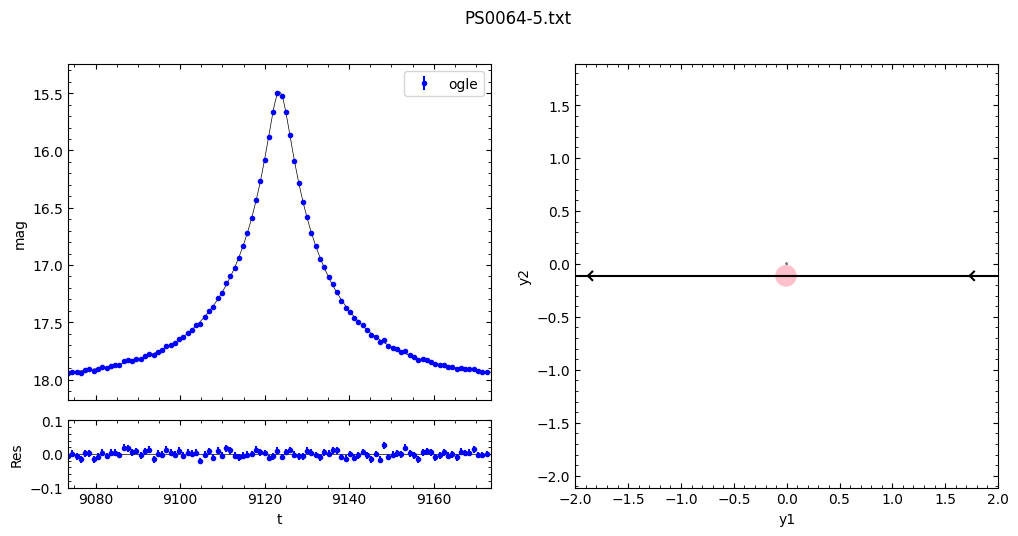

╒════════╤═══════════════════╕
│ chi2   │ 79.339803134301   │
╞════════╪═══════════════════╡
│ u0     │ 0.1124 +- 0.0091  │
├────────┼───────────────────┤
│ tE     │ 25.00 +- 0.56     │
├────────┼───────────────────┤
│ t0     │ 9123.485 +- 0.013 │
├────────┼───────────────────┤
│ rho    │ 0.095 +- 0.023    │
╘════════╧═══════════════════╛

╒═════════════╤═══════════════════╤═════════════════╕
│ telescope   │ baseline          │ blending        │
╞═════════════╪═══════════════════╪═════════════════╡
│ ogle        │ 17.9999 +- 0.0038 │ -0.002 +- 0.030 │
╘═════════════╧═══════════════════╧═════════════════╛

Note: This is the same plot type shown in section 3.6
If you added astrometric data in 3.10.1 and re-ran RTModel, the right panel will show astrometry.


In [71]:
# 1. Combined Light Curve and Astrometry
# This is the main RTModel plot showing data, model fit, and parameters
myplot = plm.plotmodel(eventname, modelfile=modelfile)

# This plot shows:
# - Left panel: Light curve with data points and model fit
# - Right panel: Astrometric trajectory (if astrometric data is available)
# - Bottom: Residuals
# - Top right: Best-fit parameters table

print("\nNote: This is the same plot type shown in section 3.6")
print("If you added astrometric data in 3.10.1 and re-ran RTModel, the right panel will show astrometry.")

No astrometric data!


<Figure size 640x480 with 0 Axes>

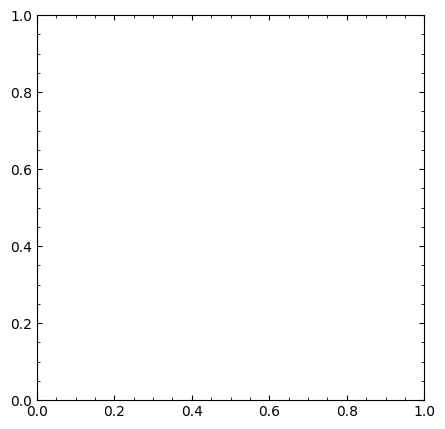

In [ ]:
# 2. Centroid Trajectory in the Sky
# NOTE: This shows RTModel's astrometric MODEL (requires parallax fitting)
myplot.showastrometry()

# This plot displays astrometric MODEL PREDICTIONS from parallax fits:
# - Centroid trajectory on the sky (North = Dec, East = RA)
# - Model prediction curves for centroid motion
# - Proper motion vector

# ⚠ This shows "No astrometric data!" because:
# - RTModel fitted a basic PS model (point-source without parallax)
# - Parallax models (PSpi) are needed for astrometric fitting
# - See the explanation and workaround plot below

No astrometric data!
No astrometric data!


<Figure size 640x480 with 0 Axes>

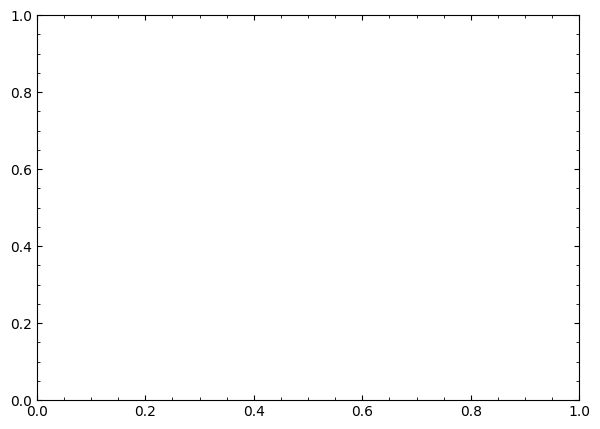

<Figure size 640x480 with 0 Axes>

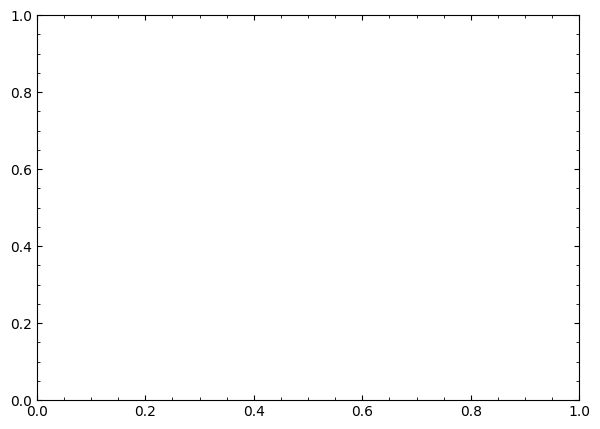

In [74]:
# 3. Individual Astrometric Components
# Shows RA and Dec shifts separately over time
myplot.showastrometryRA()  # RA vs time
myplot.showastrometryDec() # Dec vs time

# These plots show:
# - Astrometric shift in each direction (RA/Dec) vs time
# - Data points with error bars
# - Model predictions
# - Useful for identifying systematic effects or direction-dependent issues

# Note: Requires astrometric data. If plots are empty, astrometric data needs to be added.

This event has data from a single telescope/filter.
For multi-telescope events, use showastrometry(telescope_index) to plot specific telescopes.
Error: list index out of range


<Figure size 640x480 with 0 Axes>

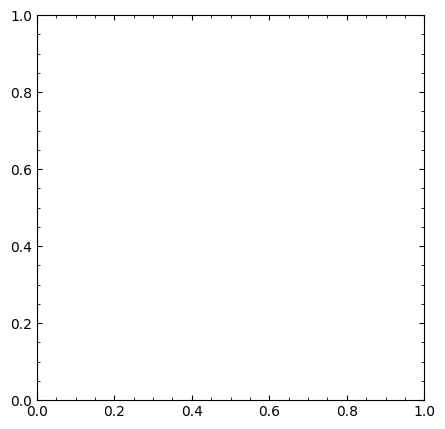

In [75]:
# 4. Multiple Telescope Support
# For events with data from multiple telescopes, you can plot specific telescopes
try:
    myplot.showastrometry(1)  # Show astrometry for telescope index 1
    # Different telescopes may have different:
    # - Astrometric precision
    # - Blending fractions
    # - Observing cadence
except (IndexError, Exception) as e:
    print("This event has data from a single telescope/filter.")
    print("For multi-telescope events, use showastrometry(telescope_index) to plot specific telescopes.")
    print(f"Error: {e}")

### Important Note About RTModel Astrometric Visualization

RTModel's `showastrometry()` function displays astrometric **model predictions** from fitted parallax parameters (not raw data). It requires that RTModel fitted **parallax models** (PSpi), which include astrometric parameters like piE_N and piE_E.

The current model is a basic **point-source (PS) model** which only fits photometric parameters (u0, tE, t0, rho) without parallax. That's why `myplot.showastrometry()` shows "No astrometric data!"

**Why RTModel didn't fit parallax models:**
- RTModel reported "Single-lens-Single-source fits with parallax - No initial conditions for this category"
- This happens when:
  - Time baseline is insufficient for parallax detection (~6 months needed)
  - RTModel doesn't automatically enable parallax for short-baseline events
  - Event needs specific configuration to force parallax fitting

**Solution:** The cell below visualizes the raw astrometric DATA directly from the `ogle_astro.dat` file (our synthetic astrometric measurements), even though RTModel didn't fit a parallax model to it.

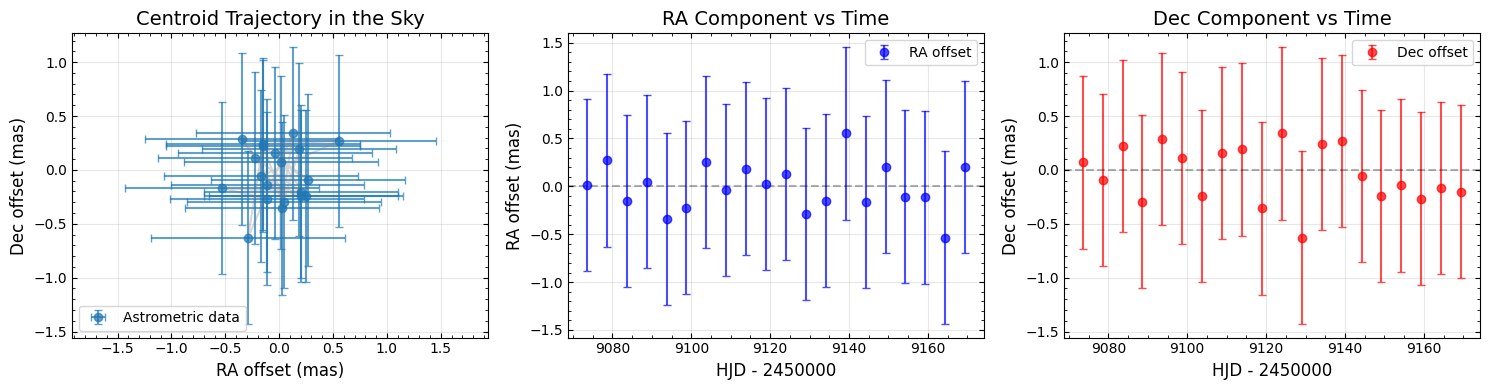


✓ Plotted 20 astrometric data points from /home/meet/data-challenge-notebooks/Extras/rtmodel_event001/Data/ogle_astro.dat
  RA range: [-0.53, 0.55] mas
  Dec range: [-0.63, 0.34] mas


In [73]:
#@title Plot Astrometric Data Directly (Workaround)
import numpy as np
import matplotlib.pyplot as plt

# Read the astrometric data file directly
ogle_astro_file = os.path.join(eventname, 'Data', 'ogle_astro.dat')

if os.path.exists(ogle_astro_file):
    # Load the astrometric data
    data = np.loadtxt(ogle_astro_file)
    
    # Extract columns: Mag, err, HJD-2450000, Dec, errDec, RA, errRA
    hjd = data[:, 2]
    dec_offset = data[:, 3]  # milliarcseconds
    dec_err = data[:, 4]
    ra_offset = data[:, 5]   # milliarcseconds  
    ra_err = data[:, 6]
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot 1: Centroid trajectory in the sky
    axes[0].errorbar(ra_offset, dec_offset, xerr=ra_err, yerr=dec_err, 
                     fmt='o', markersize=6, capsize=3, alpha=0.7, label='Astrometric data')
    axes[0].plot(ra_offset, dec_offset, '-', alpha=0.3, color='gray')
    axes[0].set_xlabel('RA offset (mas)', fontsize=12)
    axes[0].set_ylabel('Dec offset (mas)', fontsize=12)
    axes[0].set_title('Centroid Trajectory in the Sky', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    axes[0].axis('equal')
    
    # Plot 2: RA vs time
    axes[1].errorbar(hjd, ra_offset, yerr=ra_err, fmt='o', markersize=6, 
                     capsize=3, alpha=0.7, color='blue', label='RA offset')
    axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1].set_xlabel('HJD - 2450000', fontsize=12)
    axes[1].set_ylabel('RA offset (mas)', fontsize=12)
    axes[1].set_title('RA Component vs Time', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot 3: Dec vs time
    axes[2].errorbar(hjd, dec_offset, yerr=dec_err, fmt='o', markersize=6,
                     capsize=3, alpha=0.7, color='red', label='Dec offset')
    axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[2].set_xlabel('HJD - 2450000', fontsize=12)
    axes[2].set_ylabel('Dec offset (mas)', fontsize=12)
    axes[2].set_title('Dec Component vs Time', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Plotted {len(hjd)} astrometric data points from {ogle_astro_file}")
    print(f"  RA range: [{ra_offset.min():.2f}, {ra_offset.max():.2f}] mas")
    print(f"  Dec range: [{dec_offset.min():.2f}, {dec_offset.max():.2f}] mas")
else:
    print(f"⚠ Astrometric data file not found: {ogle_astro_file}")
    print("  Run cell 116 (section 3.10.1) to create astrometric data")

5. Key Features:

   - Automatic error ellipse plotting
   - Time evolution of centroid position
   - Comparison with observed astrometric data
   - Proper motion vector visualization

6. Example Output:
   - Centroid trajectory shows the astrometric microlensing signal
   - Peak season data has highest precision
   - Post-peak data constrains proper motion and parallax
   - Error bars reflect astrometric precision (typically 0.5-1.0 mas)

**Physical Interpretation of Astrophotometric Parameters:**

1. Einstein Angle ($\theta_E$)
> $\theta_E = \sqrt{(4GM/c^2D_L)}$
- Direct measurement of lens mass and distance
- Breaks the mass-distance degeneracy
- Typical values: 0.1-1.0 mas for stellar lenses

2. Source Proper Motion ($\mu_S$)
> $\mu_S = v_S / D_S$
- Tangential velocity of source star
- Helps constrain source distance and kinematics
- Typical values: 1-10 mas/yr for Galactic sources

3. Source Parallax ($\pi_S$)
$\pi_S = 1/D_S$
- Geometric parallax of source star
- Provides independent distance measurement
- Typical values: $0.1-1.0 \,\text{mas}$ for Galactic sources

4. Centroid Trajectory
- Shows the motion of the light centroid during the event
- Amplitude depends on lens mass and source-lens separation
- Shape reveals lens geometry (single vs binary)
- Duration related to Einstein time

5. Advantages of Astrophotometric Fitting
- Breaks degeneracies in lens mass and distance
- Provides independent constraints on source properties
- Enables direct measurement of Einstein angle
- Improves parameter precision and accuracy
- Essential for space-based microlensing surveys

#### <font face="Helvetica" size="4"> 3.10.5 Applications and Use Cases </font>

Astrophotometric fitting is particularly valuable for specific types of observations and scientific goals.

**Key Applications of Astrophotometric Microlensing:**

1. Space-Based Surveys (Roman, Euclid)
- Milliarcsecond astrometric precision
- Wide-field astrometric capabilities
- Long-term monitoring of events
- Essential for mass and distance measurements

2. Adaptive Optics Observations
- Ground-based high-resolution imaging
- Resolved source and lens components
- Precise centroid measurements
- Complementary to photometric data

3. Planetary Microlensing
- Direct measurement of planet masses
- Breaking mass-distance degeneracies
- Improved orbital parameter constraints
- Better characterization of planetary systems

4. Free-Floating Planets
- Mass measurement without host star
- Distance determination
- Population statistics
- Formation mechanism constraints

5. Binary Lens Systems
- Improved caustic crossing predictions
- Better orbital motion constraints
- Enhanced binary parameter determination
- More accurate mass ratio measurements

6. Galactic Structure Studies
- Source and lens distance measurements
- Proper motion distributions
- Kinematic information
- Population synthesis constraints

**Best Practices for Astrophotometric Fitting:**

1. Data Quality Requirements
- Astrometric precision: $< 1 \,\text{mas}$ (preferably $< 0.5 \,\text{mas}$)
- Temporal coverage: Peak + post-peak monitoring
- Reference frame stability
- Proper error estimation

2. Observational Strategy
- High-cadence observations during peak
- Long-term follow-up for proper motion
- Multiple epochs for parallax measurement
- Consistent reference frame

3. Model Selection
- Start with simple models (`PX`)
- Add complexity as needed (`LX`, `LO`)
- Consider eccentric orbital motion (`LK`)
- Validate against physical constraints

### 4. Parameter Validation
- Check Einstein angle physical plausibility
- Verify proper motion consistency
- Validate parallax measurements
- Compare with independent constraints

### 5. Interpretation Challenges
- Blending effects on centroid
- Reference frame systematics
- Proper motion vs parallax degeneracy
- Binary lens complexity

### 6. Future Prospects
- Roman Space Telescope: $\sim 0.1 \,\text{mas}$ precision
- Euclid: Wide-field astrometry
- Ground-based AO: High-resolution follow-up
- Multi-wavelength astrometry

## 4. popclass: Probabilistic Classification of Microlensing Lenses

### What is popclass?

**popclass** is a Python package developed by LLNL (lead: Peter McGill) for *probabilistic classification* of the lens in a gravitational microlensing event. It bridges the gap between event posteriors (from light curve modeling) and population synthesis simulations of the Milky Way, allowing you to infer the probability that a given event was caused by a star, white dwarf, neutron star, or black hole.

- **Key use:** Given posterior samples (e.g., from MulensModel, pyLIMA, or any Bayesian fit) and a Galactic population model, popclass computes the probability that the lens belongs to each class.
- **Why use it?** It enables population-level inference, e.g., identifying likely black hole events, and is designed for the era of large surveys (Roman, Rubin).

### <font face="Helvetica" size="5"> 4.1 Installation </font>

```bash
pip install popclass
```
or via conda:
```bash
conda install -c conda-forge popclass
```

### <font face="Helvetica" size="5"> 4.2 Basic Usage Example </font>

Suppose you have posterior samples for an event in log10(tE) and log10(piE):

#### ⚠️ Important: popclass Version Requirement

This section requires **popclass >= 0.2.2** for compatibility with asdf 5.x. 

If you encounter an error about `open_asdf() got an unexpected keyword argument 'copy_arrays'`, you need to upgrade popclass:

```bash
pip install --upgrade "git+https://github.com/LLNL/popclass.git@main"
```

Then **restart the kernel** (Kernel → Restart Kernel) to load the new version.

In [83]:
!pip install --upgrade "git+https://github.com/LLNL/popclass.git@main"

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/LLNL/popclass.git (to revision main) to /tmp/pip-req-build-c59f493o
  Running command git clone --filter=blob:none --quiet https://github.com/LLNL/popclass.git /tmp/pip-req-build-c59f493o
  Resolved https://github.com/LLNL/popclass.git to commit 7ae559e76166c223be9ef6f39d8b8e58e10641df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [86]:
#@title Classification of a Microlensing Event Using `popclass`
# NOTE: This requires popclass >= 0.2.2 for asdf 5.x compatibility
# If you see "copy_arrays" error, restart the kernel after installing:
# pip install --upgrade "git+https://github.com/LLNL/popclass.git@main"

import sys
import importlib

# Force reload popclass to get the latest version
if 'popclass' in sys.modules:
    print("Reloading popclass modules...")
    # Remove all popclass submodules from cache
    modules_to_remove = [m for m in sys.modules.keys() if m.startswith('popclass')]
    for m in modules_to_remove:
        del sys.modules[m]

import numpy as np
from popclass.posterior import Posterior
from popclass.model import PopulationModel
from popclass.classify import classify

# Verify we're using the updated version
print(f"Python: {sys.executable}")
import pkgutil
popclass_path = pkgutil.get_loader('popclass').get_filename()
print(f"popclass path: {popclass_path}")

# Mock posterior samples
NUM_POSTERIOR_SAMPLES = 10000
logtE = np.random.normal(loc=2, scale=0.1, size=NUM_POSTERIOR_SAMPLES)
logpiE = np.random.normal(loc=-1, scale=0.5, size=NUM_POSTERIOR_SAMPLES)
posterior_samples = np.vstack((logtE, logpiE)).T
prior_density = 0.028 * np.ones(NUM_POSTERIOR_SAMPLES)  # uniform prior

# Wrap in popclass objects
posterior = Posterior(samples=posterior_samples, parameter_labels=['log10tE', 'log10piE'])
inference_data = posterior.to_inference_data(prior_density)

# Load the population model from the library
print("\nLoading population model...")
popsycle = PopulationModel.from_library('popsycle_singles_sukhboldn20')
print("✓ Model loaded successfully!")

# Classify the event!
print("\nClassifying microlensing event...")
classification = classify(population_model=popsycle, inference_data=inference_data, parameters=['log10tE', 'log10piE'])

print("\nLens classification probabilities:")
for lens_type, probability in classification.items():
    print(f"  {lens_type:15s}: {probability:.3f}")

Reloading popclass modules...
Python: /usr/bin/python
popclass path: /home/meet/.local/lib/python3.10/site-packages/popclass/__init__.py

Loading population model...
✓ Model loaded successfully!

Classifying microlensing event...

Lens classification probabilities:
  black_hole     : 0.096
  neutron_star   : 0.001
  star           : 0.705
  white_dwarf    : 0.197


**Output:**
`{'black_hole': 0.09, 'neutron_star': 0.001, 'star': 0.71, 'white_dwarf': 0.20}`


### <font face="Helvetica" size="5"> 4.3 How It Works </font>

- **Inputs:** Posterior samples for event parameters (e.g., `tE`, `piE`), their prior densities, and a Galactic population model (e.g., from PopSyCLE).
- **Method:** Uses Bayesian importance sampling to compare the event's posterior to simulated populations, computing the probability for each lens class.
- **Output:** A dictionary of class probabilities (star, white dwarf, neutron star, black hole).

**Mathematical summary:**
$
p(\text{class}_L| \boldsymbol{d}, \mathcal{G}) = \frac{p(\text{class}_L| \mathcal{G})}{p(\boldsymbol{d}| \mathcal{G})}
    \times \frac{1}{S} \sum _{c=0}^{S} \frac{p(\theta _c | \text{class}_L, \mathcal{G})}{\pi(\theta _{c})}
$
where:
- $ \boldsymbol{d} $: event data
- $ \mathcal{G} $: Galactic model
- $ \theta_c $: posterior samples
- $ \pi(\theta_c) $: prior density

### <font face="Helvetica" size="5"> 4.4 Population Models </font>

popclass comes with several pre-built population models (from PopSyCLE), e.g.:
- `popsycle_singles_sukhboldn20`
- `popsycle_singles_raithel18`
- `popsycle_singles_spera15`

You can also load your own models in ASDF format.

### <font face="Helvetica" size="5"> 4.5 Advanced Features </font>

- **Flexible parameter spaces:** Use any set of event parameters (e.g., `tE`, `piE`, `thetaE`, `blend_fraction`).
- **Custom population models:** Supply your own simulation data in the required format.
- **Uncertainty quantification:** Includes a "None" class to flag events not well explained by the model.
- **ArviZ and PyMultiNest integration:** For handling posteriors from common Bayesian tools.
- **Plotting:** Built-in tools for visualizing classification results.

### <font face="Helvetica" size="5"> 4.6 Best Practices & Caveats </font>

- **Parameter consistency:** Ensure your posterior and population model use the same parameterization (e.g., both in `log10(tE)`, not `tE`).
- **Prior density:** Must match the parameter space of the population model (apply Jacobian if transforming variables).
- **Model completeness:** If your event is outside the simulated parameter space, the "None" class will help flag this.
- **Interpretation:** Probabilities are only as good as the population model and the event posterior.

### <font face="Helvetica" size="5"> 4.7 Further Reading </font>

- [popclass documentation](https://popclass.readthedocs.io)
- [PopSyCLE population models](https://github.com/jluastro/PopSyCLE)
- Perkins et al. (2024), Kaczmarek et al. (2024) — theoretical background

> **popclass** is a powerful tool for population-level inference in microlensing, enabling robust, probabilistic classification of lens types for large event samples.

## Contributing

We welcome contributions to improve this tutorial! Whether you want to add new tools, enhance existing sections, or fix issues, please check out our contributing guidelines below.

<div align="center">
  <a href="https://github.com/rges-pit/data-challenge-noteboooks/blob/main/CONTRIBUTING.md">
    <img src="https://github.com/AmberLee2427/microlens-submit/blob/main/docs/_static/github-desktop_logo.png?raw=1" alt="GitHub" width="20" height="20" style="vertical-align: middle; margin-right: 8px;"/>
    <span style="font-size: 16px; font-weight: 500; color: #0366d6; text-decoration: none;">Contributing to This Tutorial</span>
  </a>
</div>

## About this Notebook

**Author(s):** Amber Malpas, Ali Crisp, Meet J. Vyas <br>
**Maintainers:** RGES-PIT Working Group 9  
**Last Updated:** 20 Nov 2025  
**Contact:** malpas.1@osu.edu

## Citations

If you use `MulensModel`, `pyLIMA`, `RTModel`, `popClass`, or this notebook for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `MulensModel`](https://github.com/rpoleski/MulensModel/blob/master/CITATION.cff)
* [Citing `pyLIMA`](https://github.com/ebachelet/pyLIMA?tab=readme-ov-file#citations)
* [Citing `RTModel`](https://github.com/valboz/RTModel#attribution)
* [Citing `popClass`](https://github.com/LLNL/popclass/blob/main/CITATION.cff)
* [Citing **Roman Microlensing Data Challenge 2026 Notebooks**](https://github.com/rges-pit/data-challenge-notebooks/blob/main/zenodo.txt)

[Top of Page](#top)
<!-- Footer Start -->

<!-- Footer End -->